In [ ]:
import networkx as nx
import random
from math import floor
import matplotlib.pyplot as plt

def graph_function(graph_input,positions):
    plt.figure(3,figsize=(12,12))
    nx.draw(graph_input, pos = positions, with_labels = True)
    plt.show()

def graph_attributes_selection(graph_input,seeds):
    random.seed(seeds)

    demand= {}
    for v in graph_input.nodes:
        demand[v] = random.randint(15,400)

    workload= {}
    for v in graph_input.nodes:
        workload[v] = random.randint(15,100)

    n_customers= {}
    for v in graph_input.nodes:
        n_customers[v] = random.randint(4,20)

    distance= {}
    for e in graph_input.edges:
        distance[e] = random.randint(5,12)


    nx.set_node_attributes(graph_input, values = n_customers, name = "n_customers")
    nx.set_node_attributes(graph_input, values = demand, name = "demand")
    nx.set_node_attributes(graph_input, values = workload, name = "workload")
    nx.set_edge_attributes(graph_input, values = distance, name = "distance")

def create_layout(graph, N):
    """
    Creates a layout for input graph to be used as input for the BVNS and TerritoryDesignProblem classes

    Parameters:
    -----------
    graph_input : networkx.Graph
        A graph representing the road network.

    Returns:
    --------
    coords : list
        A list of tuples containing the coordinates of the nodes.
    grid_pos : dict
        A dictionary containing coordinates of grid positions.
    """
    GRID_ORIGIN = nx.grid_2d_graph(N,N)
    labels=dict(((i,j),i + (N-1-j)*N) for i, j in GRID_ORIGIN.nodes())
    # nx.relabel_nodes(DEDE,labels,False) #False=relabel the nodes in place
    inds=labels.keys()
    vals=labels.values()
    inds=[(N-j-1,N-i-1) for i,j in inds]

    #Create the dictionary of positions for the grid
    grid_pos=dict(zip(vals,inds))

    #turn the keys in grid_pos to strings
    grid_pos = {str(k):v for k,v in grid_pos.items()}

    for i in list(grid_pos):
        if i not in graph.nodes:
            grid_pos.pop(i)
    coords = []
    for i in inds:
        for key, value in grid_pos.items():
            if i == value:
                coords.append(i)

    return grid_pos,coords

def create_and_manipulate_graph(grid_size,region,seedNumber):
    random.seed(seedNumber)
    # Define the regions based on grid_size
    if grid_size == 27:
        regions = {
            'R1': [str(i * 27 + j) for i in range(13) for j in range(9)],
            'R2': [str(i * 27 + j) for i in range(13, 27) for j in range(9)],
            'R3': [str(i * 27 + j) for i in range(9) for j in range(9, 18)],
            'R4': [str(i * 27 + j) for i in range(9, 18) for j in range(9, 18)],
            'R5': [str(i * 27 + j) for i in range(18, 27) for j in range(9, 18)],
            'R6': [str(i * 27 + j) for i in range(13) for j in range(18, 27)],
            'R7': [str(i * 27 + j) for i in range(13, 27) for j in range(18, 27)]
        }
    elif grid_size == 33:
        regions = {
            'R1': [str(i * 33 + j) for i in range(16) for j in range(11)],
            'R2': [str(i * 33 + j) for i in range(16, 33) for j in range(11)],
            'R3': [str(i * 33 + j) for i in range(11) for j in range(11, 22)],
            'R4': [str(i * 33 + j) for i in range(11, 22) for j in range(11, 22)],
            'R5': [str(i * 33 + j) for i in range(22, 33) for j in range(11, 22)],
            'R6': [str(i * 33 + j) for i in range(16) for j in range(22, 33)],
            'R7': [str(i * 33 + j) for i in range(16, 33) for j in range(22, 33)]
        }
    elif grid_size == 30:
        regions = {
            'R1': [str(i * 30 + j) for i in range(15) for j in range(10)],
            'R2': [str(i * 30 + j) for i in range(15, 30) for j in range(10)],
            'R3': [str(i * 30 + j) for i in range(10) for j in range(10, 20)],
            'R4': [str(i * 30 + j) for i in range(10, 20) for j in range(10, 20)],
            'R5': [str(i * 30 + j) for i in range(20, 30) for j in range(10, 20)],
            'R6': [str(i * 30 + j) for i in range(15) for j in range(20, 30)],
            'R7': [str(i * 30 + j) for i in range(15, 30) for j in range(20, 30)]
        }
    else:
        raise ValueError("Invalid grid_size. Supported values are 27 and 33.")

    
    if region == "Corners":
        region_to_remove = regions['R1'] + regions['R2'] + regions['R7'] + regions['R6']
        outside_to_remove = regions['R3'] + regions['R4'] + regions['R5']
    if region == "Center":
        region_to_remove = regions['R3']+regions['R4']+regions['R5']
        outside_to_remove = regions['R1']+regions['R2']+regions['R6']+regions['R7']
    if region == "Diagonal":
        region_to_remove = regions['R1']+regions['R4']+regions['R7']
        outside_to_remove = regions['R2']+regions['R3']+regions['R5']+regions['R6']

    n = (grid_size * grid_size) - (grid_size * grid_size)/3

    # for i in range(10):
    connected_final = False
    
    while not connected_final:
        graph = nx.grid_2d_graph(grid_size, grid_size)
        graph = nx.relabel_nodes(graph, {(i, j): str(i * grid_size + j) for i in range(grid_size) for j in range(grid_size)})
        grid_pos,coords = create_layout(graph,grid_size)
        region_removal = floor(2 / 3 * (grid_size * grid_size - n))
        outside_removal = floor(1 / 3 * (grid_size * grid_size - n))

        def remove_region(graph):
            region_to_remove = regions['R1'] + regions['R2'] + regions['R7'] + regions['R6']

            i = 0
            while i < region_removal:
                node_to_remove = random.choice(region_to_remove)
                G_COPY = graph.copy()
                graph.remove_node(node_to_remove)
                region_to_remove.remove(node_to_remove)
                if not nx.is_connected(graph):
                    graph = G_COPY.copy()
                    region_to_remove.append(node_to_remove)
                else:
                    i += 1
            return graph

        def remove_outside_region(graph):
            outside_to_remove = regions['R3'] + regions['R4'] + regions['R5']
            j = 0
            while j < outside_removal:
                node_to_remove = random.choice(outside_to_remove)
                G_COP = graph.copy()
                graph.remove_node(node_to_remove)
                outside_to_remove.remove(node_to_remove)
                if not nx.is_connected(graph):
                    graph = G_COP.copy()
                    outside_to_remove.append(node_to_remove)
                else:
                    j += 1
            return graph

        graph = remove_region(graph)
        print(f'Done with {region} removal')
        graph = remove_outside_region(graph)
        print(f'Done with outside {region} removal')

        connected_final = nx.is_connected(graph)
    
#     graph_function(graph, grid_pos)
    print(len(graph.nodes()))
    print("Graph connected:", connected_final)
    graph_attributes_selection(graph,seedNumber)

    return graph

In [43]:
import networkx as nx
import random
from math import floor
import matplotlib.pyplot as plt

In [44]:
def graph_function(graph_input,positions):
    plt.figure(3,figsize=(12,12))
    nx.draw(graph_input, pos = positions, with_labels = True, node_size=400, node_color='lime')
    plt.show()

In [45]:
def graph_attributes_selection(graph_input,seeds):
    random.seed(seeds)

    demand= {}
    for v in graph_input.nodes:
        demand[v] = random.randint(15,400)

    workload= {}
    for v in graph_input.nodes:
        workload[v] = random.randint(15,100)

    n_customers= {}
    for v in graph_input.nodes:
        n_customers[v] = random.randint(4,20)

    distance= {}
    for e in graph_input.edges:
        distance[e] = random.randint(5,12)


    nx.set_node_attributes(graph_input, values = n_customers, name = "n_customers")
    nx.set_node_attributes(graph_input, values = demand, name = "demand")
    nx.set_node_attributes(graph_input, values = workload, name = "workload")
    nx.set_edge_attributes(graph_input, values = distance, name = "distance")

In [46]:
def create_layout(graph, N):
    """
    Creates a layout for input graph to be used as input for the BVNS and TerritoryDesignProblem classes

    Parameters:
    -----------
    graph_input : networkx.Graph
        A graph representing the road network.

    Returns:
    --------
    coords : list
        A list of tuples containing the coordinates of the nodes.
    grid_pos : dict
        A dictionary containing coordinates of grid positions.
    """
    GRID_ORIGIN = nx.grid_2d_graph(N,N)
    labels=dict(((i,j),i + (N-1-j)*N) for i, j in GRID_ORIGIN.nodes())
    # nx.relabel_nodes(DEDE,labels,False) #False=relabel the nodes in place
    inds=labels.keys()
    vals=labels.values()
    inds=[(N-j-1,N-i-1) for i,j in inds]

    #Create the dictionary of positions for the grid
    grid_pos=dict(zip(vals,inds))

    #turn the keys in grid_pos to strings
    grid_pos = {str(k):v for k,v in grid_pos.items()}

    for i in list(grid_pos):
        if i not in graph.nodes:
            grid_pos.pop(i)
    coords = []
    for i in inds:
        for key, value in grid_pos.items():
            if i == value:
                coords.append(i)

    return grid_pos,coords

In [47]:
def create_and_manipulate_graph(grid_size,region,seedNumber):
    random.seed(seedNumber)
    # Define the regions based on grid_size
    if grid_size == 27:
        regions = {
            'R1': [str(i * 27 + j) for i in range(13) for j in range(9)],
            'R2': [str(i * 27 + j) for i in range(13, 27) for j in range(9)],
            'R3': [str(i * 27 + j) for i in range(9) for j in range(9, 18)],
            'R4': [str(i * 27 + j) for i in range(9, 18) for j in range(9, 18)],
            'R5': [str(i * 27 + j) for i in range(18, 27) for j in range(9, 18)],
            'R6': [str(i * 27 + j) for i in range(13) for j in range(18, 27)],
            'R7': [str(i * 27 + j) for i in range(13, 27) for j in range(18, 27)]
        }
    elif grid_size == 33:
        regions = {
            'R1': [str(i * 33 + j) for i in range(16) for j in range(11)],
            'R2': [str(i * 33 + j) for i in range(16, 33) for j in range(11)],
            'R3': [str(i * 33 + j) for i in range(11) for j in range(11, 22)],
            'R4': [str(i * 33 + j) for i in range(11, 22) for j in range(11, 22)],
            'R5': [str(i * 33 + j) for i in range(22, 33) for j in range(11, 22)],
            'R6': [str(i * 33 + j) for i in range(16) for j in range(22, 33)],
            'R7': [str(i * 33 + j) for i in range(16, 33) for j in range(22, 33)]
        }
    elif grid_size == 30:
        regions = {
            'R1': [str(i * 30 + j) for i in range(15) for j in range(10)],
            'R2': [str(i * 30 + j) for i in range(15, 30) for j in range(10)],
            'R3': [str(i * 30 + j) for i in range(10) for j in range(10, 20)],
            'R4': [str(i * 30 + j) for i in range(10, 20) for j in range(10, 20)],
            'R5': [str(i * 30 + j) for i in range(20, 30) for j in range(10, 20)],
            'R6': [str(i * 30 + j) for i in range(15) for j in range(20, 30)],
            'R7': [str(i * 30 + j) for i in range(15, 30) for j in range(20, 30)]
        }
    else:
        raise ValueError("Invalid grid_size. Supported values are 27 and 33.")

    
    if region == "Corners":
        region_to_remove = regions['R1'] + regions['R2'] + regions['R7'] + regions['R6']
        outside_to_remove = regions['R3'] + regions['R4'] + regions['R5']
    if region == "Center":
        region_to_remove = regions['R3']+regions['R4']+regions['R5']
        outside_to_remove = regions['R1']+regions['R2']+regions['R6']+regions['R7']
    if region == "Diagonal":
        region_to_remove = regions['R1']+regions['R4']+regions['R7']
        outside_to_remove = regions['R2']+regions['R3']+regions['R5']+regions['R6']

    n = (grid_size * grid_size) - (grid_size * grid_size)/3

    # for i in range(10):
    connected_final = False
    
    while not connected_final:
        graph = nx.grid_2d_graph(grid_size, grid_size)
        graph = nx.relabel_nodes(graph, {(i, j): str(i * grid_size + j) for i in range(grid_size) for j in range(grid_size)})
        grid_pos,coords = create_layout(graph,grid_size)
        region_removal = floor(2 / 3 * (grid_size * grid_size - n))
        outside_removal = floor(1 / 3 * (grid_size * grid_size - n))

        def remove_region(graph, region_to_remove, region_removal):
#             region_to_remove = regions['R1'] + regions['R2'] + regions['R7'] + regions['R6']

            i = 0
            while i < region_removal:
                node_to_remove = random.choice(region_to_remove)
                G_COPY = graph.copy()
                graph.remove_node(node_to_remove)
                region_to_remove.remove(node_to_remove)
                if not nx.is_connected(graph):
                    graph = G_COPY.copy()
                    region_to_remove.append(node_to_remove)
                else:
                    i += 1
            return graph

#         def remove_outside_region(graph, outside_to_remove):
# #             outside_to_remove = regions['R3'] + regions['R4'] + regions['R5']
#             j = 0
#             while j < outside_removal:
#                 node_to_remove = random.choice(outside_to_remove)
#                 G_COP = graph.copy()
#                 graph.remove_node(node_to_remove)
#                 outside_to_remove.remove(node_to_remove)
#                 if not nx.is_connected(graph):
#                     graph = G_COP.copy()
#                     outside_to_remove.append(node_to_remove)
#                 else:
#                     j += 1
#             return graph

#         graph = remove_region(graph)
        graph = remove_region(graph, region_to_remove, region_removal)
        print(f'Done with {region} removal')
#         graph = remove_outside_region(graph)
        graph = remove_region(graph, outside_to_remove, outside_removal)
        print(f'Done with outside {region} removal')

        connected_final = nx.is_connected(graph)
    
    # graph_function(graph, grid_pos)
    print(len(graph.nodes()))
    print("Graph connected:", connected_final)
    graph_attributes_selection(graph,seedNumber)

    return graph

In [48]:
import os
# Define the directory path and file extension
directory_path = 'newGeneratedInstances'
file_extension = '.graphml'

if not os.path.exists(directory_path):
    os.makedirs(directory_path, exist_ok=True)

for grid_size in [27,30,33]:
    for region in ["Center", "Corners", "Diagonal"]:
        
        for graph_idx in range(10):
            
            seed=f"{grid_size}_{region}_{graph_idx}"
            
            graph = create_and_manipulate_graph(grid_size,region,seed)
            
            grid_size_directory_path = f'{directory_path}/{grid_size}x{grid_size}Graphs/'
            if not os.path.exists(grid_size_directory_path):
                os.makedirs(grid_size_directory_path, exist_ok=True)

            graph_name = f'{region}{int((grid_size*grid_size)-(grid_size*grid_size)/3)}_G{graph_idx}'
            
            output_file_path = f'{grid_size_directory_path}/{graph_name}{file_extension}'
            
            nx.write_graphml(graph, output_file_path)      

Done with Center removal
Done with outside Center removal
486
Graph connected: True
Done with Center removal
Done with outside Center removal
486
Graph connected: True
Done with Center removal
Done with outside Center removal
486
Graph connected: True
Done with Center removal
Done with outside Center removal
486
Graph connected: True
Done with Center removal
Done with outside Center removal
486
Graph connected: True
Done with Center removal
Done with outside Center removal
486
Graph connected: True
Done with Center removal
Done with outside Center removal
486
Graph connected: True
Done with Center removal
Done with outside Center removal
486
Graph connected: True
Done with Center removal
Done with outside Center removal
486
Graph connected: True
Done with Center removal
Done with outside Center removal
486
Graph connected: True
Done with Corners removal
Done with outside Corners removal
486
Graph connected: True
Done with Corners removal
Done with outside Corners removal
486
Graph conn

In [ ]:
# Example usage

#Choose grid size between [27,30,33]
grid_size = 27

#Choose between 3 regions ["Center", "Corners", "Diagonal"]
region = "Center"

#Choose the seed for graph generation and attributes
seedNumber = 7

graph = create_and_manipulate_graph(grid_size,region,seedNumber)
nx.write_graphml(graph, f'newGeneratedInstances/{grid_size}x{grid_size}Graphs/{region}{int((grid_size*grid_size)-(grid_size*grid_size)/3)}_G{seedNumber}.graphml')

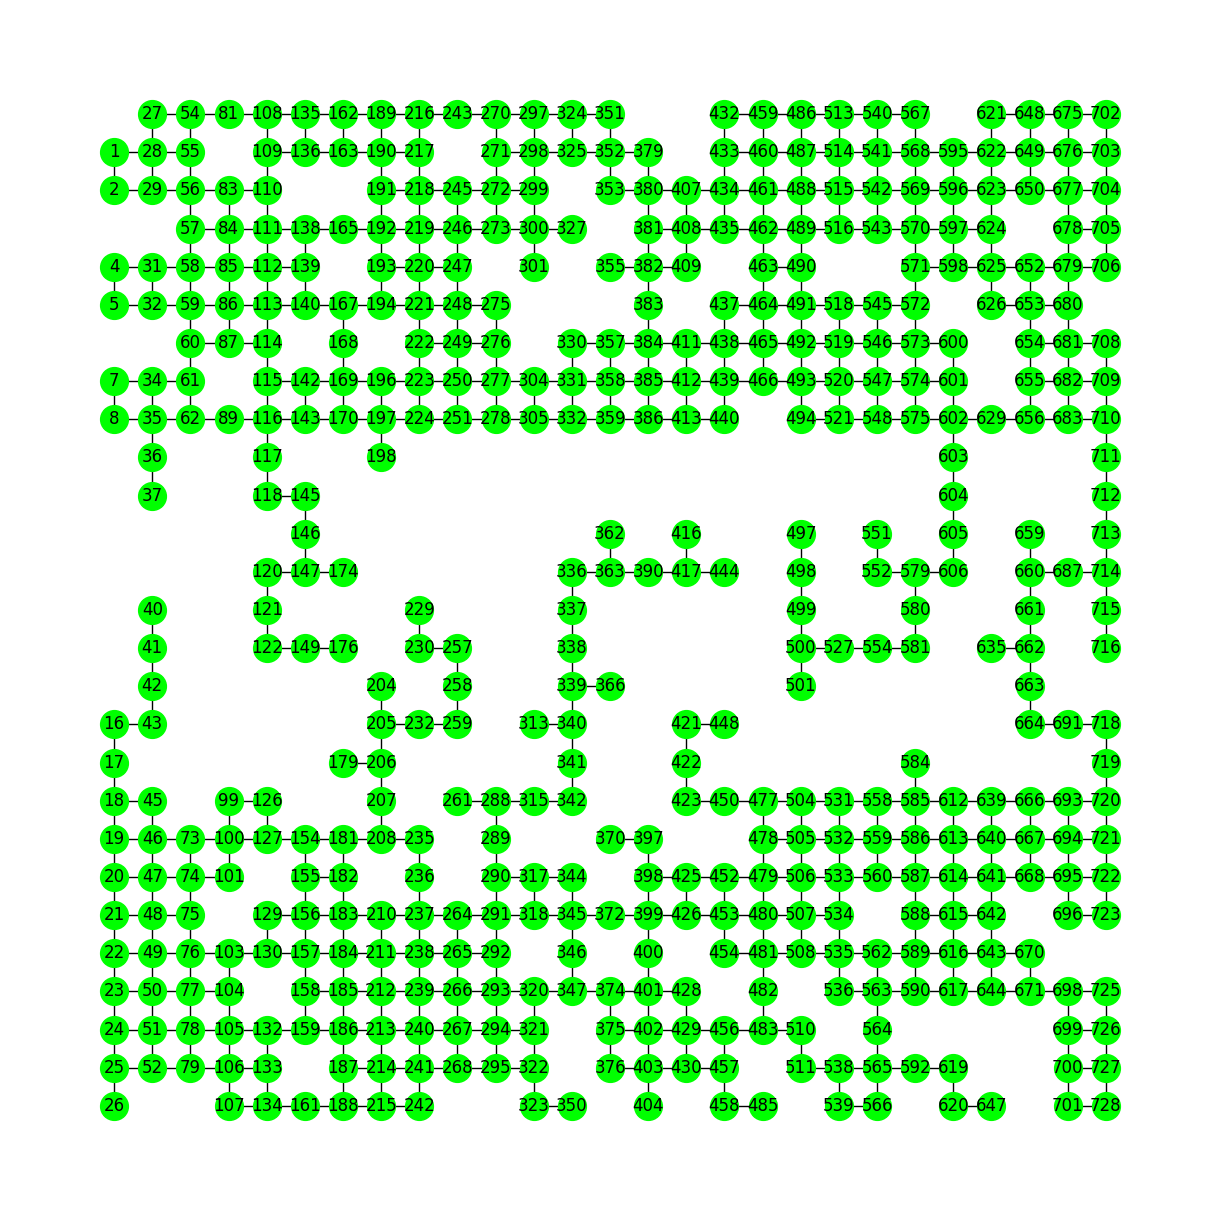

In [49]:
graph = nx.read_graphml('newGeneratedInstances/27x27Graphs/Center486_G7.graphml')

# graph = create_and_manipulate_graph(27,'Center','center10')
grid_pos, coords = create_layout(graph,27)
graph_function(graph, grid_pos)

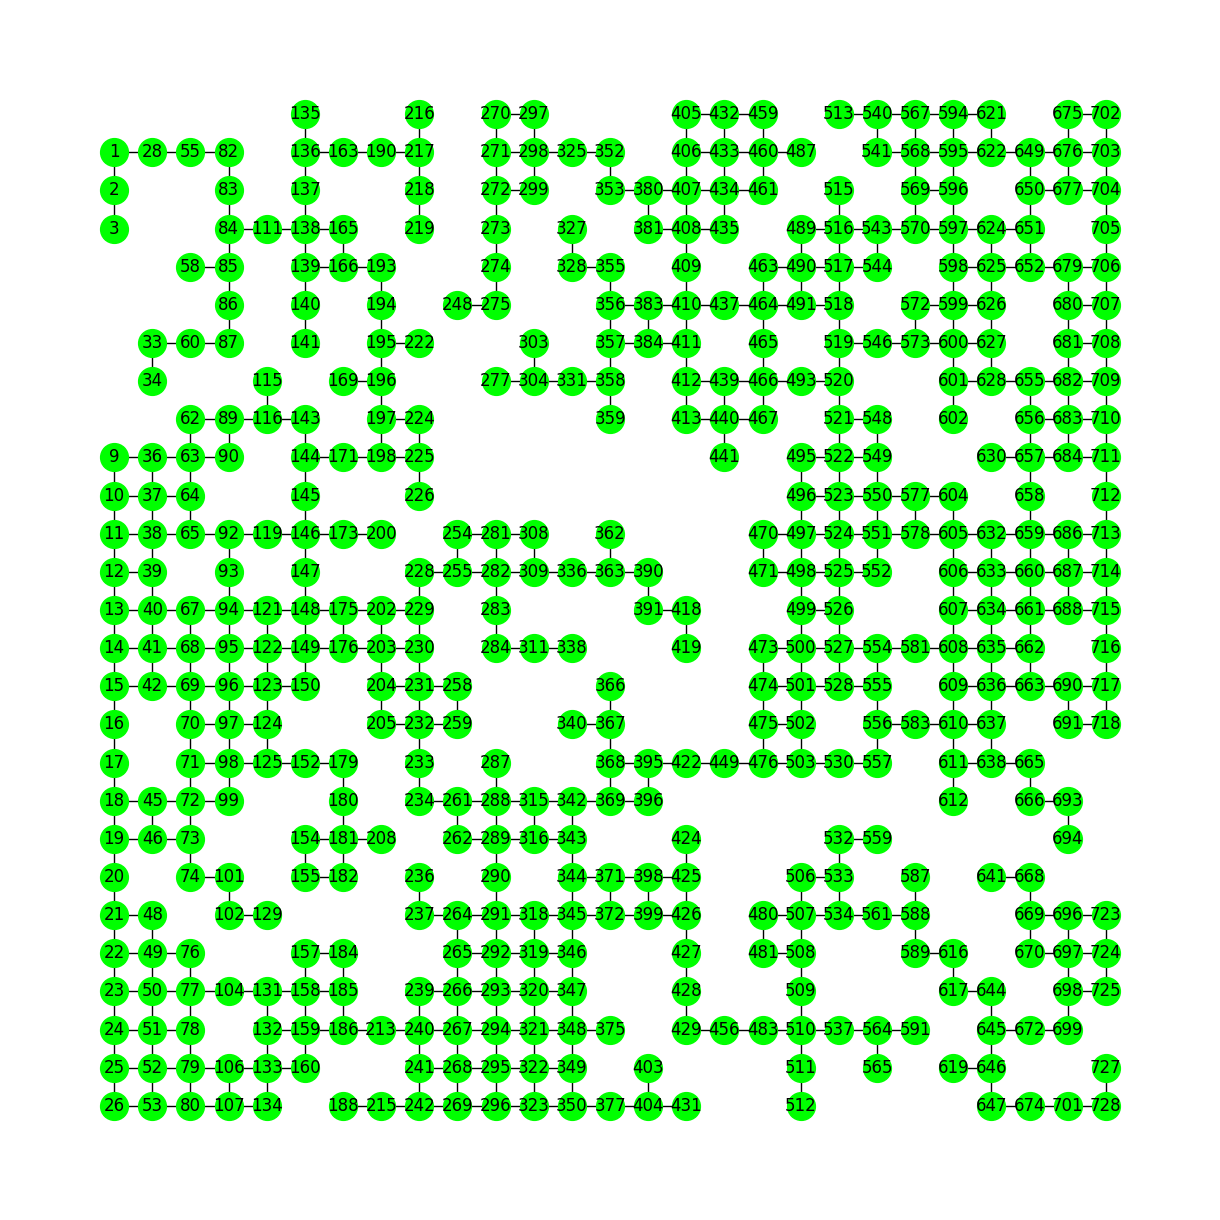

In [50]:
graph = nx.read_graphml('newGeneratedInstances/27x27Graphs/Diagonal486_G3.graphml')
# graph = create_and_manipulate_graph(27,'Diagonal','diagona')
grid_pos, coords = create_layout(graph,27)
graph_function(graph, grid_pos)

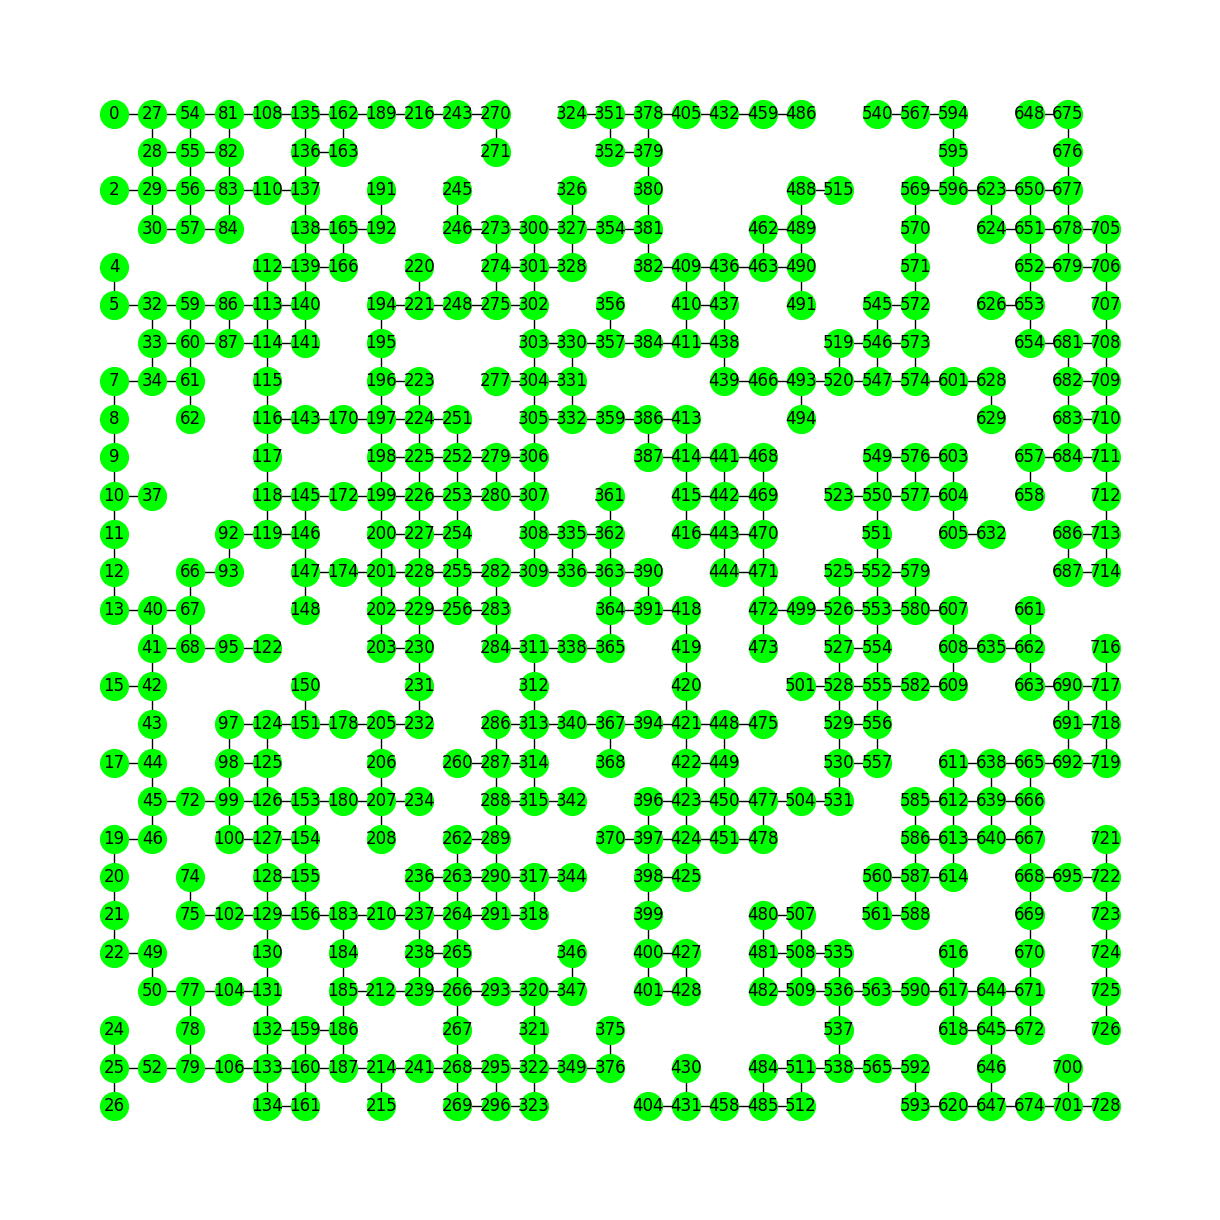

In [51]:
graph = nx.read_graphml('newGeneratedInstances/27x27Graphs/Corners486_G9.graphml')
# graph = create_and_manipulate_graph(27,'Corners','corners')
grid_pos, coords = create_layout(graph,27)
graph_function(graph, grid_pos)

# Create adjusted graphs

In [52]:
import os
import random
import networkx as nx
from math import floor
from itertools import product


# Define the attribute ranges
attribute_ranges = {
    'demand': {'low': (15, 150), 'high': (150, 400)},
    'workload': {'low': (15, 30), 'high': (30, 100)},
    'n_customers': {'low': (4, 8), 'high': (8, 20)}
}

# Define the percentages for low attribute values
low_percentages = [0.25, 0.50, 0.90]

# Define the directory path and file extension
directory_path = 'newGeneratedInstances'
file_extension = '.graphml'

percentage_combinations = list(product(low_percentages, repeat=len(attribute_ranges)))

for combination in percentage_combinations:
    for folder_path, _, files in os.walk(directory_path):
        if 'Adjusted' not in folder_path and len(files) and '.ipynb_checkpoints' not in folder_path:
            combination_folder = f"newGeneratedInstances/Adjusted/d{combination[0]}_w{combination[1]}_c{combination[2]}/{folder_path.split('/')[1]}"
            os.makedirs(combination_folder, exist_ok=True)
            for file_name in files:
                # print(folder_path, filename)
                if file_name.endswith('.graphml') and 'checkpoint' not in file_name:
                    file_path = os.path.join(folder_path, file_name)
                    print(file_path, file_name)

                    graph = nx.read_graphml(file_path)

                    low_demand_nodes = list(random.sample(list(graph.nodes()),floor(combination[0]*len(list(graph.nodes())))))
                    low_workload_nodes = list(random.sample(list(graph.nodes()),floor(combination[1]*len(list(graph.nodes())))))
                    low_n_customers_nodes = list(random.sample(list(graph.nodes()),floor(combination[2]*len(list(graph.nodes())))))

                    for node in list(graph.nodes()):
                        attribute_values = graph.nodes[node]
                        new_attribute_values = {}
                        if node in low_demand_nodes:
                            new_attribute_values['demand'] = random.randint(*attribute_ranges['demand']['low'])
                        else:
                            new_attribute_values['demand'] = random.randint(*attribute_ranges['demand']['high'])

                        if node in low_workload_nodes:
                            new_attribute_values['workload'] = random.randint(*attribute_ranges['workload']['low'])
                        else:
                            new_attribute_values['workload'] = random.randint(*attribute_ranges['workload']['high'])

                        if node in low_n_customers_nodes:
                            new_attribute_values['n_customers'] = random.randint(*attribute_ranges['n_customers']['low'])
                        else:
                            new_attribute_values['n_customers'] = random.randint(*attribute_ranges['n_customers']['high'])

                        attribute_values.update(new_attribute_values)

                    output_file_path = f"{combination_folder}/{file_name}"
                    print(output_file_path)
                    nx.write_graphml(graph, output_file_path)


newGeneratedInstances/27x27Graphs/Center486_G6.graphml Center486_G6.graphml
newGeneratedInstances/Adjusted/d0.25_w0.25_c0.25/27x27Graphs/Center486_G6.graphml
newGeneratedInstances/27x27Graphs/Center486_G9.graphml Center486_G9.graphml
newGeneratedInstances/Adjusted/d0.25_w0.25_c0.25/27x27Graphs/Center486_G9.graphml
newGeneratedInstances/27x27Graphs/Center486_G1.graphml Center486_G1.graphml
newGeneratedInstances/Adjusted/d0.25_w0.25_c0.25/27x27Graphs/Center486_G1.graphml
newGeneratedInstances/27x27Graphs/Corners486_G3.graphml Corners486_G3.graphml
newGeneratedInstances/Adjusted/d0.25_w0.25_c0.25/27x27Graphs/Corners486_G3.graphml
newGeneratedInstances/27x27Graphs/Diagonal486_G2.graphml Diagonal486_G2.graphml
newGeneratedInstances/Adjusted/d0.25_w0.25_c0.25/27x27Graphs/Diagonal486_G2.graphml
newGeneratedInstances/27x27Graphs/Corners486_G9.graphml Corners486_G9.graphml
newGeneratedInstances/Adjusted/d0.25_w0.25_c0.25/27x27Graphs/Corners486_G9.graphml
newGeneratedInstances/27x27Graphs/Corner

newGeneratedInstances/Adjusted/d0.25_w0.25_c0.25/33x33Graphs/Center726_G9.graphml
newGeneratedInstances/33x33Graphs/Center726_G3.graphml Center726_G3.graphml
newGeneratedInstances/Adjusted/d0.25_w0.25_c0.25/33x33Graphs/Center726_G3.graphml
newGeneratedInstances/33x33Graphs/Center726_G6.graphml Center726_G6.graphml
newGeneratedInstances/Adjusted/d0.25_w0.25_c0.25/33x33Graphs/Center726_G6.graphml
newGeneratedInstances/33x33Graphs/Corners726_G6.graphml Corners726_G6.graphml
newGeneratedInstances/Adjusted/d0.25_w0.25_c0.25/33x33Graphs/Corners726_G6.graphml
newGeneratedInstances/33x33Graphs/Diagonal726_G2.graphml Diagonal726_G2.graphml
newGeneratedInstances/Adjusted/d0.25_w0.25_c0.25/33x33Graphs/Diagonal726_G2.graphml
newGeneratedInstances/33x33Graphs/Center726_G5.graphml Center726_G5.graphml
newGeneratedInstances/Adjusted/d0.25_w0.25_c0.25/33x33Graphs/Center726_G5.graphml
newGeneratedInstances/30x30Graphs/Corners600_G8.graphml Corners600_G8.graphml
newGeneratedInstances/Adjusted/d0.25_w0.2

newGeneratedInstances/27x27Graphs/Diagonal486_G5.graphml Diagonal486_G5.graphml
newGeneratedInstances/Adjusted/d0.25_w0.25_c0.5/27x27Graphs/Diagonal486_G5.graphml
newGeneratedInstances/27x27Graphs/Corners486_G7.graphml Corners486_G7.graphml
newGeneratedInstances/Adjusted/d0.25_w0.25_c0.5/27x27Graphs/Corners486_G7.graphml
newGeneratedInstances/27x27Graphs/Corners486_G2.graphml Corners486_G2.graphml
newGeneratedInstances/Adjusted/d0.25_w0.25_c0.5/27x27Graphs/Corners486_G2.graphml
newGeneratedInstances/27x27Graphs/Diagonal486_G9.graphml Diagonal486_G9.graphml
newGeneratedInstances/Adjusted/d0.25_w0.25_c0.5/27x27Graphs/Diagonal486_G9.graphml
newGeneratedInstances/27x27Graphs/Diagonal486_G1.graphml Diagonal486_G1.graphml
newGeneratedInstances/Adjusted/d0.25_w0.25_c0.5/27x27Graphs/Diagonal486_G1.graphml
newGeneratedInstances/27x27Graphs/Diagonal486_G3.graphml Diagonal486_G3.graphml
newGeneratedInstances/Adjusted/d0.25_w0.25_c0.5/27x27Graphs/Diagonal486_G3.graphml
newGeneratedInstances/27x27G

newGeneratedInstances/30x30Graphs/Diagonal600_G3.graphml Diagonal600_G3.graphml
newGeneratedInstances/Adjusted/d0.25_w0.25_c0.5/30x30Graphs/Diagonal600_G3.graphml
newGeneratedInstances/30x30Graphs/Corners600_G5.graphml Corners600_G5.graphml
newGeneratedInstances/Adjusted/d0.25_w0.25_c0.5/30x30Graphs/Corners600_G5.graphml
newGeneratedInstances/30x30Graphs/Center600_G9.graphml Center600_G9.graphml
newGeneratedInstances/Adjusted/d0.25_w0.25_c0.5/30x30Graphs/Center600_G9.graphml
newGeneratedInstances/30x30Graphs/Corners600_G2.graphml Corners600_G2.graphml
newGeneratedInstances/Adjusted/d0.25_w0.25_c0.5/30x30Graphs/Corners600_G2.graphml
newGeneratedInstances/30x30Graphs/Diagonal600_G2.graphml Diagonal600_G2.graphml
newGeneratedInstances/Adjusted/d0.25_w0.25_c0.5/30x30Graphs/Diagonal600_G2.graphml
newGeneratedInstances/30x30Graphs/Diagonal600_G1.graphml Diagonal600_G1.graphml
newGeneratedInstances/Adjusted/d0.25_w0.25_c0.5/30x30Graphs/Diagonal600_G1.graphml
newGeneratedInstances/30x30Graphs/

newGeneratedInstances/Adjusted/d0.25_w0.25_c0.9/33x33Graphs/Corners726_G1.graphml
newGeneratedInstances/33x33Graphs/Diagonal726_G1.graphml Diagonal726_G1.graphml
newGeneratedInstances/Adjusted/d0.25_w0.25_c0.9/33x33Graphs/Diagonal726_G1.graphml
newGeneratedInstances/33x33Graphs/Diagonal726_G7.graphml Diagonal726_G7.graphml
newGeneratedInstances/Adjusted/d0.25_w0.25_c0.9/33x33Graphs/Diagonal726_G7.graphml
newGeneratedInstances/33x33Graphs/Center726_G7.graphml Center726_G7.graphml
newGeneratedInstances/Adjusted/d0.25_w0.25_c0.9/33x33Graphs/Center726_G7.graphml
newGeneratedInstances/33x33Graphs/Diagonal726_G0.graphml Diagonal726_G0.graphml
newGeneratedInstances/Adjusted/d0.25_w0.25_c0.9/33x33Graphs/Diagonal726_G0.graphml
newGeneratedInstances/33x33Graphs/Corners726_G9.graphml Corners726_G9.graphml
newGeneratedInstances/Adjusted/d0.25_w0.25_c0.9/33x33Graphs/Corners726_G9.graphml
newGeneratedInstances/33x33Graphs/Diagonal726_G4.graphml Diagonal726_G4.graphml
newGeneratedInstances/Adjusted/d

newGeneratedInstances/Adjusted/d0.25_w0.25_c0.9/30x30Graphs/Diagonal600_G4.graphml
newGeneratedInstances/30x30Graphs/Center600_G0.graphml Center600_G0.graphml
newGeneratedInstances/Adjusted/d0.25_w0.25_c0.9/30x30Graphs/Center600_G0.graphml
newGeneratedInstances/30x30Graphs/Corners600_G0.graphml Corners600_G0.graphml
newGeneratedInstances/Adjusted/d0.25_w0.25_c0.9/30x30Graphs/Corners600_G0.graphml
newGeneratedInstances/27x27Graphs/Center486_G6.graphml Center486_G6.graphml
newGeneratedInstances/Adjusted/d0.25_w0.5_c0.25/27x27Graphs/Center486_G6.graphml
newGeneratedInstances/27x27Graphs/Center486_G9.graphml Center486_G9.graphml
newGeneratedInstances/Adjusted/d0.25_w0.5_c0.25/27x27Graphs/Center486_G9.graphml
newGeneratedInstances/27x27Graphs/Center486_G1.graphml Center486_G1.graphml
newGeneratedInstances/Adjusted/d0.25_w0.5_c0.25/27x27Graphs/Center486_G1.graphml
newGeneratedInstances/27x27Graphs/Corners486_G3.graphml Corners486_G3.graphml
newGeneratedInstances/Adjusted/d0.25_w0.5_c0.25/27x

newGeneratedInstances/Adjusted/d0.25_w0.5_c0.25/33x33Graphs/Corners726_G0.graphml
newGeneratedInstances/33x33Graphs/Center726_G4.graphml Center726_G4.graphml
newGeneratedInstances/Adjusted/d0.25_w0.5_c0.25/33x33Graphs/Center726_G4.graphml
newGeneratedInstances/33x33Graphs/Corners726_G3.graphml Corners726_G3.graphml
newGeneratedInstances/Adjusted/d0.25_w0.5_c0.25/33x33Graphs/Corners726_G3.graphml
newGeneratedInstances/33x33Graphs/Center726_G9.graphml Center726_G9.graphml
newGeneratedInstances/Adjusted/d0.25_w0.5_c0.25/33x33Graphs/Center726_G9.graphml
newGeneratedInstances/33x33Graphs/Center726_G3.graphml Center726_G3.graphml
newGeneratedInstances/Adjusted/d0.25_w0.5_c0.25/33x33Graphs/Center726_G3.graphml
newGeneratedInstances/33x33Graphs/Center726_G6.graphml Center726_G6.graphml
newGeneratedInstances/Adjusted/d0.25_w0.5_c0.25/33x33Graphs/Center726_G6.graphml
newGeneratedInstances/33x33Graphs/Corners726_G6.graphml Corners726_G6.graphml
newGeneratedInstances/Adjusted/d0.25_w0.5_c0.25/33x3

newGeneratedInstances/27x27Graphs/Corners486_G1.graphml Corners486_G1.graphml
newGeneratedInstances/Adjusted/d0.25_w0.5_c0.5/27x27Graphs/Corners486_G1.graphml
newGeneratedInstances/27x27Graphs/Corners486_G0.graphml Corners486_G0.graphml
newGeneratedInstances/Adjusted/d0.25_w0.5_c0.5/27x27Graphs/Corners486_G0.graphml
newGeneratedInstances/27x27Graphs/Center486_G2.graphml Center486_G2.graphml
newGeneratedInstances/Adjusted/d0.25_w0.5_c0.5/27x27Graphs/Center486_G2.graphml
newGeneratedInstances/27x27Graphs/Center486_G0.graphml Center486_G0.graphml
newGeneratedInstances/Adjusted/d0.25_w0.5_c0.5/27x27Graphs/Center486_G0.graphml
newGeneratedInstances/27x27Graphs/Diagonal486_G5.graphml Diagonal486_G5.graphml
newGeneratedInstances/Adjusted/d0.25_w0.5_c0.5/27x27Graphs/Diagonal486_G5.graphml
newGeneratedInstances/27x27Graphs/Corners486_G7.graphml Corners486_G7.graphml
newGeneratedInstances/Adjusted/d0.25_w0.5_c0.5/27x27Graphs/Corners486_G7.graphml
newGeneratedInstances/27x27Graphs/Corners486_G2.g

newGeneratedInstances/30x30Graphs/Corners600_G1.graphml Corners600_G1.graphml
newGeneratedInstances/Adjusted/d0.25_w0.5_c0.5/30x30Graphs/Corners600_G1.graphml
newGeneratedInstances/30x30Graphs/Corners600_G4.graphml Corners600_G4.graphml
newGeneratedInstances/Adjusted/d0.25_w0.5_c0.5/30x30Graphs/Corners600_G4.graphml
newGeneratedInstances/30x30Graphs/Corners600_G6.graphml Corners600_G6.graphml
newGeneratedInstances/Adjusted/d0.25_w0.5_c0.5/30x30Graphs/Corners600_G6.graphml
newGeneratedInstances/30x30Graphs/Diagonal600_G6.graphml Diagonal600_G6.graphml
newGeneratedInstances/Adjusted/d0.25_w0.5_c0.5/30x30Graphs/Diagonal600_G6.graphml
newGeneratedInstances/30x30Graphs/Diagonal600_G3.graphml Diagonal600_G3.graphml
newGeneratedInstances/Adjusted/d0.25_w0.5_c0.5/30x30Graphs/Diagonal600_G3.graphml
newGeneratedInstances/30x30Graphs/Corners600_G5.graphml Corners600_G5.graphml
newGeneratedInstances/Adjusted/d0.25_w0.5_c0.5/30x30Graphs/Corners600_G5.graphml
newGeneratedInstances/30x30Graphs/Center

newGeneratedInstances/Adjusted/d0.25_w0.5_c0.9/27x27Graphs/Center486_G5.graphml
newGeneratedInstances/27x27Graphs/Corners486_G6.graphml Corners486_G6.graphml
newGeneratedInstances/Adjusted/d0.25_w0.5_c0.9/27x27Graphs/Corners486_G6.graphml
newGeneratedInstances/33x33Graphs/Center726_G2.graphml Center726_G2.graphml
newGeneratedInstances/Adjusted/d0.25_w0.5_c0.9/33x33Graphs/Center726_G2.graphml
newGeneratedInstances/33x33Graphs/Corners726_G2.graphml Corners726_G2.graphml
newGeneratedInstances/Adjusted/d0.25_w0.5_c0.9/33x33Graphs/Corners726_G2.graphml
newGeneratedInstances/33x33Graphs/Corners726_G1.graphml Corners726_G1.graphml
newGeneratedInstances/Adjusted/d0.25_w0.5_c0.9/33x33Graphs/Corners726_G1.graphml
newGeneratedInstances/33x33Graphs/Diagonal726_G1.graphml Diagonal726_G1.graphml
newGeneratedInstances/Adjusted/d0.25_w0.5_c0.9/33x33Graphs/Diagonal726_G1.graphml
newGeneratedInstances/33x33Graphs/Diagonal726_G7.graphml Diagonal726_G7.graphml
newGeneratedInstances/Adjusted/d0.25_w0.5_c0.

newGeneratedInstances/30x30Graphs/Center600_G3.graphml Center600_G3.graphml
newGeneratedInstances/Adjusted/d0.25_w0.5_c0.9/30x30Graphs/Center600_G3.graphml
newGeneratedInstances/30x30Graphs/Center600_G7.graphml Center600_G7.graphml
newGeneratedInstances/Adjusted/d0.25_w0.5_c0.9/30x30Graphs/Center600_G7.graphml
newGeneratedInstances/30x30Graphs/Center600_G2.graphml Center600_G2.graphml
newGeneratedInstances/Adjusted/d0.25_w0.5_c0.9/30x30Graphs/Center600_G2.graphml
newGeneratedInstances/30x30Graphs/Center600_G4.graphml Center600_G4.graphml
newGeneratedInstances/Adjusted/d0.25_w0.5_c0.9/30x30Graphs/Center600_G4.graphml
newGeneratedInstances/30x30Graphs/Diagonal600_G5.graphml Diagonal600_G5.graphml
newGeneratedInstances/Adjusted/d0.25_w0.5_c0.9/30x30Graphs/Diagonal600_G5.graphml
newGeneratedInstances/30x30Graphs/Center600_G8.graphml Center600_G8.graphml
newGeneratedInstances/Adjusted/d0.25_w0.5_c0.9/30x30Graphs/Center600_G8.graphml
newGeneratedInstances/30x30Graphs/Center600_G1.graphml Cen

newGeneratedInstances/33x33Graphs/Diagonal726_G5.graphml Diagonal726_G5.graphml
newGeneratedInstances/Adjusted/d0.25_w0.9_c0.25/33x33Graphs/Diagonal726_G5.graphml
newGeneratedInstances/33x33Graphs/Corners726_G8.graphml Corners726_G8.graphml
newGeneratedInstances/Adjusted/d0.25_w0.9_c0.25/33x33Graphs/Corners726_G8.graphml
newGeneratedInstances/33x33Graphs/Diagonal726_G9.graphml Diagonal726_G9.graphml
newGeneratedInstances/Adjusted/d0.25_w0.9_c0.25/33x33Graphs/Diagonal726_G9.graphml
newGeneratedInstances/33x33Graphs/Corners726_G5.graphml Corners726_G5.graphml
newGeneratedInstances/Adjusted/d0.25_w0.9_c0.25/33x33Graphs/Corners726_G5.graphml
newGeneratedInstances/33x33Graphs/Center726_G0.graphml Center726_G0.graphml
newGeneratedInstances/Adjusted/d0.25_w0.9_c0.25/33x33Graphs/Center726_G0.graphml
newGeneratedInstances/33x33Graphs/Diagonal726_G8.graphml Diagonal726_G8.graphml
newGeneratedInstances/Adjusted/d0.25_w0.9_c0.25/33x33Graphs/Diagonal726_G8.graphml
newGeneratedInstances/33x33Graphs/

newGeneratedInstances/27x27Graphs/Center486_G7.graphml Center486_G7.graphml
newGeneratedInstances/Adjusted/d0.25_w0.9_c0.5/27x27Graphs/Center486_G7.graphml
newGeneratedInstances/27x27Graphs/Diagonal486_G7.graphml Diagonal486_G7.graphml
newGeneratedInstances/Adjusted/d0.25_w0.9_c0.5/27x27Graphs/Diagonal486_G7.graphml
newGeneratedInstances/27x27Graphs/Diagonal486_G6.graphml Diagonal486_G6.graphml
newGeneratedInstances/Adjusted/d0.25_w0.9_c0.5/27x27Graphs/Diagonal486_G6.graphml
newGeneratedInstances/27x27Graphs/Diagonal486_G0.graphml Diagonal486_G0.graphml
newGeneratedInstances/Adjusted/d0.25_w0.9_c0.5/27x27Graphs/Diagonal486_G0.graphml
newGeneratedInstances/27x27Graphs/Corners486_G1.graphml Corners486_G1.graphml
newGeneratedInstances/Adjusted/d0.25_w0.9_c0.5/27x27Graphs/Corners486_G1.graphml
newGeneratedInstances/27x27Graphs/Corners486_G0.graphml Corners486_G0.graphml
newGeneratedInstances/Adjusted/d0.25_w0.9_c0.5/27x27Graphs/Corners486_G0.graphml
newGeneratedInstances/27x27Graphs/Center

newGeneratedInstances/Adjusted/d0.25_w0.9_c0.5/30x30Graphs/Center600_G5.graphml
newGeneratedInstances/30x30Graphs/Center600_G6.graphml Center600_G6.graphml
newGeneratedInstances/Adjusted/d0.25_w0.9_c0.5/30x30Graphs/Center600_G6.graphml
newGeneratedInstances/30x30Graphs/Corners600_G7.graphml Corners600_G7.graphml
newGeneratedInstances/Adjusted/d0.25_w0.9_c0.5/30x30Graphs/Corners600_G7.graphml
newGeneratedInstances/30x30Graphs/Corners600_G9.graphml Corners600_G9.graphml
newGeneratedInstances/Adjusted/d0.25_w0.9_c0.5/30x30Graphs/Corners600_G9.graphml
newGeneratedInstances/30x30Graphs/Diagonal600_G0.graphml Diagonal600_G0.graphml
newGeneratedInstances/Adjusted/d0.25_w0.9_c0.5/30x30Graphs/Diagonal600_G0.graphml
newGeneratedInstances/30x30Graphs/Corners600_G1.graphml Corners600_G1.graphml
newGeneratedInstances/Adjusted/d0.25_w0.9_c0.5/30x30Graphs/Corners600_G1.graphml
newGeneratedInstances/30x30Graphs/Corners600_G4.graphml Corners600_G4.graphml
newGeneratedInstances/Adjusted/d0.25_w0.9_c0.5/

newGeneratedInstances/Adjusted/d0.25_w0.9_c0.9/27x27Graphs/Center486_G5.graphml
newGeneratedInstances/27x27Graphs/Corners486_G6.graphml Corners486_G6.graphml
newGeneratedInstances/Adjusted/d0.25_w0.9_c0.9/27x27Graphs/Corners486_G6.graphml
newGeneratedInstances/33x33Graphs/Center726_G2.graphml Center726_G2.graphml
newGeneratedInstances/Adjusted/d0.25_w0.9_c0.9/33x33Graphs/Center726_G2.graphml
newGeneratedInstances/33x33Graphs/Corners726_G2.graphml Corners726_G2.graphml
newGeneratedInstances/Adjusted/d0.25_w0.9_c0.9/33x33Graphs/Corners726_G2.graphml
newGeneratedInstances/33x33Graphs/Corners726_G1.graphml Corners726_G1.graphml
newGeneratedInstances/Adjusted/d0.25_w0.9_c0.9/33x33Graphs/Corners726_G1.graphml
newGeneratedInstances/33x33Graphs/Diagonal726_G1.graphml Diagonal726_G1.graphml
newGeneratedInstances/Adjusted/d0.25_w0.9_c0.9/33x33Graphs/Diagonal726_G1.graphml
newGeneratedInstances/33x33Graphs/Diagonal726_G7.graphml Diagonal726_G7.graphml
newGeneratedInstances/Adjusted/d0.25_w0.9_c0.

newGeneratedInstances/Adjusted/d0.25_w0.9_c0.9/30x30Graphs/Diagonal600_G5.graphml
newGeneratedInstances/30x30Graphs/Center600_G8.graphml Center600_G8.graphml
newGeneratedInstances/Adjusted/d0.25_w0.9_c0.9/30x30Graphs/Center600_G8.graphml
newGeneratedInstances/30x30Graphs/Center600_G1.graphml Center600_G1.graphml
newGeneratedInstances/Adjusted/d0.25_w0.9_c0.9/30x30Graphs/Center600_G1.graphml
newGeneratedInstances/30x30Graphs/Diagonal600_G4.graphml Diagonal600_G4.graphml
newGeneratedInstances/Adjusted/d0.25_w0.9_c0.9/30x30Graphs/Diagonal600_G4.graphml
newGeneratedInstances/30x30Graphs/Center600_G0.graphml Center600_G0.graphml
newGeneratedInstances/Adjusted/d0.25_w0.9_c0.9/30x30Graphs/Center600_G0.graphml
newGeneratedInstances/30x30Graphs/Corners600_G0.graphml Corners600_G0.graphml
newGeneratedInstances/Adjusted/d0.25_w0.9_c0.9/30x30Graphs/Corners600_G0.graphml
newGeneratedInstances/27x27Graphs/Center486_G6.graphml Center486_G6.graphml
newGeneratedInstances/Adjusted/d0.5_w0.25_c0.25/27x27

newGeneratedInstances/Adjusted/d0.5_w0.25_c0.25/33x33Graphs/Diagonal726_G9.graphml
newGeneratedInstances/33x33Graphs/Corners726_G5.graphml Corners726_G5.graphml
newGeneratedInstances/Adjusted/d0.5_w0.25_c0.25/33x33Graphs/Corners726_G5.graphml
newGeneratedInstances/33x33Graphs/Center726_G0.graphml Center726_G0.graphml
newGeneratedInstances/Adjusted/d0.5_w0.25_c0.25/33x33Graphs/Center726_G0.graphml
newGeneratedInstances/33x33Graphs/Diagonal726_G8.graphml Diagonal726_G8.graphml
newGeneratedInstances/Adjusted/d0.5_w0.25_c0.25/33x33Graphs/Diagonal726_G8.graphml
newGeneratedInstances/33x33Graphs/Corners726_G0.graphml Corners726_G0.graphml
newGeneratedInstances/Adjusted/d0.5_w0.25_c0.25/33x33Graphs/Corners726_G0.graphml
newGeneratedInstances/33x33Graphs/Center726_G4.graphml Center726_G4.graphml
newGeneratedInstances/Adjusted/d0.5_w0.25_c0.25/33x33Graphs/Center726_G4.graphml
newGeneratedInstances/33x33Graphs/Corners726_G3.graphml Corners726_G3.graphml
newGeneratedInstances/Adjusted/d0.5_w0.25_

newGeneratedInstances/27x27Graphs/Diagonal486_G0.graphml Diagonal486_G0.graphml
newGeneratedInstances/Adjusted/d0.5_w0.25_c0.5/27x27Graphs/Diagonal486_G0.graphml
newGeneratedInstances/27x27Graphs/Corners486_G1.graphml Corners486_G1.graphml
newGeneratedInstances/Adjusted/d0.5_w0.25_c0.5/27x27Graphs/Corners486_G1.graphml
newGeneratedInstances/27x27Graphs/Corners486_G0.graphml Corners486_G0.graphml
newGeneratedInstances/Adjusted/d0.5_w0.25_c0.5/27x27Graphs/Corners486_G0.graphml
newGeneratedInstances/27x27Graphs/Center486_G2.graphml Center486_G2.graphml
newGeneratedInstances/Adjusted/d0.5_w0.25_c0.5/27x27Graphs/Center486_G2.graphml
newGeneratedInstances/27x27Graphs/Center486_G0.graphml Center486_G0.graphml
newGeneratedInstances/Adjusted/d0.5_w0.25_c0.5/27x27Graphs/Center486_G0.graphml
newGeneratedInstances/27x27Graphs/Diagonal486_G5.graphml Diagonal486_G5.graphml
newGeneratedInstances/Adjusted/d0.5_w0.25_c0.5/27x27Graphs/Diagonal486_G5.graphml
newGeneratedInstances/27x27Graphs/Corners486_G

newGeneratedInstances/30x30Graphs/Corners600_G1.graphml Corners600_G1.graphml
newGeneratedInstances/Adjusted/d0.5_w0.25_c0.5/30x30Graphs/Corners600_G1.graphml
newGeneratedInstances/30x30Graphs/Corners600_G4.graphml Corners600_G4.graphml
newGeneratedInstances/Adjusted/d0.5_w0.25_c0.5/30x30Graphs/Corners600_G4.graphml
newGeneratedInstances/30x30Graphs/Corners600_G6.graphml Corners600_G6.graphml
newGeneratedInstances/Adjusted/d0.5_w0.25_c0.5/30x30Graphs/Corners600_G6.graphml
newGeneratedInstances/30x30Graphs/Diagonal600_G6.graphml Diagonal600_G6.graphml
newGeneratedInstances/Adjusted/d0.5_w0.25_c0.5/30x30Graphs/Diagonal600_G6.graphml
newGeneratedInstances/30x30Graphs/Diagonal600_G3.graphml Diagonal600_G3.graphml
newGeneratedInstances/Adjusted/d0.5_w0.25_c0.5/30x30Graphs/Diagonal600_G3.graphml
newGeneratedInstances/30x30Graphs/Corners600_G5.graphml Corners600_G5.graphml
newGeneratedInstances/Adjusted/d0.5_w0.25_c0.5/30x30Graphs/Corners600_G5.graphml
newGeneratedInstances/30x30Graphs/Center

newGeneratedInstances/Adjusted/d0.5_w0.25_c0.9/33x33Graphs/Corners726_G1.graphml
newGeneratedInstances/33x33Graphs/Diagonal726_G1.graphml Diagonal726_G1.graphml
newGeneratedInstances/Adjusted/d0.5_w0.25_c0.9/33x33Graphs/Diagonal726_G1.graphml
newGeneratedInstances/33x33Graphs/Diagonal726_G7.graphml Diagonal726_G7.graphml
newGeneratedInstances/Adjusted/d0.5_w0.25_c0.9/33x33Graphs/Diagonal726_G7.graphml
newGeneratedInstances/33x33Graphs/Center726_G7.graphml Center726_G7.graphml
newGeneratedInstances/Adjusted/d0.5_w0.25_c0.9/33x33Graphs/Center726_G7.graphml
newGeneratedInstances/33x33Graphs/Diagonal726_G0.graphml Diagonal726_G0.graphml
newGeneratedInstances/Adjusted/d0.5_w0.25_c0.9/33x33Graphs/Diagonal726_G0.graphml
newGeneratedInstances/33x33Graphs/Corners726_G9.graphml Corners726_G9.graphml
newGeneratedInstances/Adjusted/d0.5_w0.25_c0.9/33x33Graphs/Corners726_G9.graphml
newGeneratedInstances/33x33Graphs/Diagonal726_G4.graphml Diagonal726_G4.graphml
newGeneratedInstances/Adjusted/d0.5_w0

newGeneratedInstances/Adjusted/d0.5_w0.25_c0.9/30x30Graphs/Center600_G1.graphml
newGeneratedInstances/30x30Graphs/Diagonal600_G4.graphml Diagonal600_G4.graphml
newGeneratedInstances/Adjusted/d0.5_w0.25_c0.9/30x30Graphs/Diagonal600_G4.graphml
newGeneratedInstances/30x30Graphs/Center600_G0.graphml Center600_G0.graphml
newGeneratedInstances/Adjusted/d0.5_w0.25_c0.9/30x30Graphs/Center600_G0.graphml
newGeneratedInstances/30x30Graphs/Corners600_G0.graphml Corners600_G0.graphml
newGeneratedInstances/Adjusted/d0.5_w0.25_c0.9/30x30Graphs/Corners600_G0.graphml
newGeneratedInstances/27x27Graphs/Center486_G6.graphml Center486_G6.graphml
newGeneratedInstances/Adjusted/d0.5_w0.5_c0.25/27x27Graphs/Center486_G6.graphml
newGeneratedInstances/27x27Graphs/Center486_G9.graphml Center486_G9.graphml
newGeneratedInstances/Adjusted/d0.5_w0.5_c0.25/27x27Graphs/Center486_G9.graphml
newGeneratedInstances/27x27Graphs/Center486_G1.graphml Center486_G1.graphml
newGeneratedInstances/Adjusted/d0.5_w0.5_c0.25/27x27Gra

newGeneratedInstances/Adjusted/d0.5_w0.5_c0.25/33x33Graphs/Corners726_G5.graphml
newGeneratedInstances/33x33Graphs/Center726_G0.graphml Center726_G0.graphml
newGeneratedInstances/Adjusted/d0.5_w0.5_c0.25/33x33Graphs/Center726_G0.graphml
newGeneratedInstances/33x33Graphs/Diagonal726_G8.graphml Diagonal726_G8.graphml
newGeneratedInstances/Adjusted/d0.5_w0.5_c0.25/33x33Graphs/Diagonal726_G8.graphml
newGeneratedInstances/33x33Graphs/Corners726_G0.graphml Corners726_G0.graphml
newGeneratedInstances/Adjusted/d0.5_w0.5_c0.25/33x33Graphs/Corners726_G0.graphml
newGeneratedInstances/33x33Graphs/Center726_G4.graphml Center726_G4.graphml
newGeneratedInstances/Adjusted/d0.5_w0.5_c0.25/33x33Graphs/Center726_G4.graphml
newGeneratedInstances/33x33Graphs/Corners726_G3.graphml Corners726_G3.graphml
newGeneratedInstances/Adjusted/d0.5_w0.5_c0.25/33x33Graphs/Corners726_G3.graphml
newGeneratedInstances/33x33Graphs/Center726_G9.graphml Center726_G9.graphml
newGeneratedInstances/Adjusted/d0.5_w0.5_c0.25/33x3

newGeneratedInstances/Adjusted/d0.5_w0.5_c0.5/27x27Graphs/Center486_G2.graphml
newGeneratedInstances/27x27Graphs/Center486_G0.graphml Center486_G0.graphml
newGeneratedInstances/Adjusted/d0.5_w0.5_c0.5/27x27Graphs/Center486_G0.graphml
newGeneratedInstances/27x27Graphs/Diagonal486_G5.graphml Diagonal486_G5.graphml
newGeneratedInstances/Adjusted/d0.5_w0.5_c0.5/27x27Graphs/Diagonal486_G5.graphml
newGeneratedInstances/27x27Graphs/Corners486_G7.graphml Corners486_G7.graphml
newGeneratedInstances/Adjusted/d0.5_w0.5_c0.5/27x27Graphs/Corners486_G7.graphml
newGeneratedInstances/27x27Graphs/Corners486_G2.graphml Corners486_G2.graphml
newGeneratedInstances/Adjusted/d0.5_w0.5_c0.5/27x27Graphs/Corners486_G2.graphml
newGeneratedInstances/27x27Graphs/Diagonal486_G9.graphml Diagonal486_G9.graphml
newGeneratedInstances/Adjusted/d0.5_w0.5_c0.5/27x27Graphs/Diagonal486_G9.graphml
newGeneratedInstances/27x27Graphs/Diagonal486_G1.graphml Diagonal486_G1.graphml
newGeneratedInstances/Adjusted/d0.5_w0.5_c0.5/27

newGeneratedInstances/30x30Graphs/Diagonal600_G6.graphml Diagonal600_G6.graphml
newGeneratedInstances/Adjusted/d0.5_w0.5_c0.5/30x30Graphs/Diagonal600_G6.graphml
newGeneratedInstances/30x30Graphs/Diagonal600_G3.graphml Diagonal600_G3.graphml
newGeneratedInstances/Adjusted/d0.5_w0.5_c0.5/30x30Graphs/Diagonal600_G3.graphml
newGeneratedInstances/30x30Graphs/Corners600_G5.graphml Corners600_G5.graphml
newGeneratedInstances/Adjusted/d0.5_w0.5_c0.5/30x30Graphs/Corners600_G5.graphml
newGeneratedInstances/30x30Graphs/Center600_G9.graphml Center600_G9.graphml
newGeneratedInstances/Adjusted/d0.5_w0.5_c0.5/30x30Graphs/Center600_G9.graphml
newGeneratedInstances/30x30Graphs/Corners600_G2.graphml Corners600_G2.graphml
newGeneratedInstances/Adjusted/d0.5_w0.5_c0.5/30x30Graphs/Corners600_G2.graphml
newGeneratedInstances/30x30Graphs/Diagonal600_G2.graphml Diagonal600_G2.graphml
newGeneratedInstances/Adjusted/d0.5_w0.5_c0.5/30x30Graphs/Diagonal600_G2.graphml
newGeneratedInstances/30x30Graphs/Diagonal600_

newGeneratedInstances/33x33Graphs/Corners726_G1.graphml Corners726_G1.graphml
newGeneratedInstances/Adjusted/d0.5_w0.5_c0.9/33x33Graphs/Corners726_G1.graphml
newGeneratedInstances/33x33Graphs/Diagonal726_G1.graphml Diagonal726_G1.graphml
newGeneratedInstances/Adjusted/d0.5_w0.5_c0.9/33x33Graphs/Diagonal726_G1.graphml
newGeneratedInstances/33x33Graphs/Diagonal726_G7.graphml Diagonal726_G7.graphml
newGeneratedInstances/Adjusted/d0.5_w0.5_c0.9/33x33Graphs/Diagonal726_G7.graphml
newGeneratedInstances/33x33Graphs/Center726_G7.graphml Center726_G7.graphml
newGeneratedInstances/Adjusted/d0.5_w0.5_c0.9/33x33Graphs/Center726_G7.graphml
newGeneratedInstances/33x33Graphs/Diagonal726_G0.graphml Diagonal726_G0.graphml
newGeneratedInstances/Adjusted/d0.5_w0.5_c0.9/33x33Graphs/Diagonal726_G0.graphml
newGeneratedInstances/33x33Graphs/Corners726_G9.graphml Corners726_G9.graphml
newGeneratedInstances/Adjusted/d0.5_w0.5_c0.9/33x33Graphs/Corners726_G9.graphml
newGeneratedInstances/33x33Graphs/Diagonal726_

newGeneratedInstances/30x30Graphs/Center600_G1.graphml Center600_G1.graphml
newGeneratedInstances/Adjusted/d0.5_w0.5_c0.9/30x30Graphs/Center600_G1.graphml
newGeneratedInstances/30x30Graphs/Diagonal600_G4.graphml Diagonal600_G4.graphml
newGeneratedInstances/Adjusted/d0.5_w0.5_c0.9/30x30Graphs/Diagonal600_G4.graphml
newGeneratedInstances/30x30Graphs/Center600_G0.graphml Center600_G0.graphml
newGeneratedInstances/Adjusted/d0.5_w0.5_c0.9/30x30Graphs/Center600_G0.graphml
newGeneratedInstances/30x30Graphs/Corners600_G0.graphml Corners600_G0.graphml
newGeneratedInstances/Adjusted/d0.5_w0.5_c0.9/30x30Graphs/Corners600_G0.graphml
newGeneratedInstances/27x27Graphs/Center486_G6.graphml Center486_G6.graphml
newGeneratedInstances/Adjusted/d0.5_w0.9_c0.25/27x27Graphs/Center486_G6.graphml
newGeneratedInstances/27x27Graphs/Center486_G9.graphml Center486_G9.graphml
newGeneratedInstances/Adjusted/d0.5_w0.9_c0.25/27x27Graphs/Center486_G9.graphml
newGeneratedInstances/27x27Graphs/Center486_G1.graphml Cent

newGeneratedInstances/33x33Graphs/Diagonal726_G8.graphml Diagonal726_G8.graphml
newGeneratedInstances/Adjusted/d0.5_w0.9_c0.25/33x33Graphs/Diagonal726_G8.graphml
newGeneratedInstances/33x33Graphs/Corners726_G0.graphml Corners726_G0.graphml
newGeneratedInstances/Adjusted/d0.5_w0.9_c0.25/33x33Graphs/Corners726_G0.graphml
newGeneratedInstances/33x33Graphs/Center726_G4.graphml Center726_G4.graphml
newGeneratedInstances/Adjusted/d0.5_w0.9_c0.25/33x33Graphs/Center726_G4.graphml
newGeneratedInstances/33x33Graphs/Corners726_G3.graphml Corners726_G3.graphml
newGeneratedInstances/Adjusted/d0.5_w0.9_c0.25/33x33Graphs/Corners726_G3.graphml
newGeneratedInstances/33x33Graphs/Center726_G9.graphml Center726_G9.graphml
newGeneratedInstances/Adjusted/d0.5_w0.9_c0.25/33x33Graphs/Center726_G9.graphml
newGeneratedInstances/33x33Graphs/Center726_G3.graphml Center726_G3.graphml
newGeneratedInstances/Adjusted/d0.5_w0.9_c0.25/33x33Graphs/Center726_G3.graphml
newGeneratedInstances/33x33Graphs/Center726_G6.graph

newGeneratedInstances/Adjusted/d0.5_w0.9_c0.5/27x27Graphs/Diagonal486_G0.graphml
newGeneratedInstances/27x27Graphs/Corners486_G1.graphml Corners486_G1.graphml
newGeneratedInstances/Adjusted/d0.5_w0.9_c0.5/27x27Graphs/Corners486_G1.graphml
newGeneratedInstances/27x27Graphs/Corners486_G0.graphml Corners486_G0.graphml
newGeneratedInstances/Adjusted/d0.5_w0.9_c0.5/27x27Graphs/Corners486_G0.graphml
newGeneratedInstances/27x27Graphs/Center486_G2.graphml Center486_G2.graphml
newGeneratedInstances/Adjusted/d0.5_w0.9_c0.5/27x27Graphs/Center486_G2.graphml
newGeneratedInstances/27x27Graphs/Center486_G0.graphml Center486_G0.graphml
newGeneratedInstances/Adjusted/d0.5_w0.9_c0.5/27x27Graphs/Center486_G0.graphml
newGeneratedInstances/27x27Graphs/Diagonal486_G5.graphml Diagonal486_G5.graphml
newGeneratedInstances/Adjusted/d0.5_w0.9_c0.5/27x27Graphs/Diagonal486_G5.graphml
newGeneratedInstances/27x27Graphs/Corners486_G7.graphml Corners486_G7.graphml
newGeneratedInstances/Adjusted/d0.5_w0.9_c0.5/27x27Gra

newGeneratedInstances/30x30Graphs/Diagonal600_G0.graphml Diagonal600_G0.graphml
newGeneratedInstances/Adjusted/d0.5_w0.9_c0.5/30x30Graphs/Diagonal600_G0.graphml
newGeneratedInstances/30x30Graphs/Corners600_G1.graphml Corners600_G1.graphml
newGeneratedInstances/Adjusted/d0.5_w0.9_c0.5/30x30Graphs/Corners600_G1.graphml
newGeneratedInstances/30x30Graphs/Corners600_G4.graphml Corners600_G4.graphml
newGeneratedInstances/Adjusted/d0.5_w0.9_c0.5/30x30Graphs/Corners600_G4.graphml
newGeneratedInstances/30x30Graphs/Corners600_G6.graphml Corners600_G6.graphml
newGeneratedInstances/Adjusted/d0.5_w0.9_c0.5/30x30Graphs/Corners600_G6.graphml
newGeneratedInstances/30x30Graphs/Diagonal600_G6.graphml Diagonal600_G6.graphml
newGeneratedInstances/Adjusted/d0.5_w0.9_c0.5/30x30Graphs/Diagonal600_G6.graphml
newGeneratedInstances/30x30Graphs/Diagonal600_G3.graphml Diagonal600_G3.graphml
newGeneratedInstances/Adjusted/d0.5_w0.9_c0.5/30x30Graphs/Diagonal600_G3.graphml
newGeneratedInstances/30x30Graphs/Corners60

newGeneratedInstances/Adjusted/d0.5_w0.9_c0.9/27x27Graphs/Corners486_G8.graphml
newGeneratedInstances/27x27Graphs/Center486_G5.graphml Center486_G5.graphml
newGeneratedInstances/Adjusted/d0.5_w0.9_c0.9/27x27Graphs/Center486_G5.graphml
newGeneratedInstances/27x27Graphs/Corners486_G6.graphml Corners486_G6.graphml
newGeneratedInstances/Adjusted/d0.5_w0.9_c0.9/27x27Graphs/Corners486_G6.graphml
newGeneratedInstances/33x33Graphs/Center726_G2.graphml Center726_G2.graphml
newGeneratedInstances/Adjusted/d0.5_w0.9_c0.9/33x33Graphs/Center726_G2.graphml
newGeneratedInstances/33x33Graphs/Corners726_G2.graphml Corners726_G2.graphml
newGeneratedInstances/Adjusted/d0.5_w0.9_c0.9/33x33Graphs/Corners726_G2.graphml
newGeneratedInstances/33x33Graphs/Corners726_G1.graphml Corners726_G1.graphml
newGeneratedInstances/Adjusted/d0.5_w0.9_c0.9/33x33Graphs/Corners726_G1.graphml
newGeneratedInstances/33x33Graphs/Diagonal726_G1.graphml Diagonal726_G1.graphml
newGeneratedInstances/Adjusted/d0.5_w0.9_c0.9/33x33Graph

newGeneratedInstances/Adjusted/d0.5_w0.9_c0.9/30x30Graphs/Center600_G3.graphml
newGeneratedInstances/30x30Graphs/Center600_G7.graphml Center600_G7.graphml
newGeneratedInstances/Adjusted/d0.5_w0.9_c0.9/30x30Graphs/Center600_G7.graphml
newGeneratedInstances/30x30Graphs/Center600_G2.graphml Center600_G2.graphml
newGeneratedInstances/Adjusted/d0.5_w0.9_c0.9/30x30Graphs/Center600_G2.graphml
newGeneratedInstances/30x30Graphs/Center600_G4.graphml Center600_G4.graphml
newGeneratedInstances/Adjusted/d0.5_w0.9_c0.9/30x30Graphs/Center600_G4.graphml
newGeneratedInstances/30x30Graphs/Diagonal600_G5.graphml Diagonal600_G5.graphml
newGeneratedInstances/Adjusted/d0.5_w0.9_c0.9/30x30Graphs/Diagonal600_G5.graphml
newGeneratedInstances/30x30Graphs/Center600_G8.graphml Center600_G8.graphml
newGeneratedInstances/Adjusted/d0.5_w0.9_c0.9/30x30Graphs/Center600_G8.graphml
newGeneratedInstances/30x30Graphs/Center600_G1.graphml Center600_G1.graphml
newGeneratedInstances/Adjusted/d0.5_w0.9_c0.9/30x30Graphs/Center

newGeneratedInstances/33x33Graphs/Diagonal726_G5.graphml Diagonal726_G5.graphml
newGeneratedInstances/Adjusted/d0.9_w0.25_c0.25/33x33Graphs/Diagonal726_G5.graphml
newGeneratedInstances/33x33Graphs/Corners726_G8.graphml Corners726_G8.graphml
newGeneratedInstances/Adjusted/d0.9_w0.25_c0.25/33x33Graphs/Corners726_G8.graphml
newGeneratedInstances/33x33Graphs/Diagonal726_G9.graphml Diagonal726_G9.graphml
newGeneratedInstances/Adjusted/d0.9_w0.25_c0.25/33x33Graphs/Diagonal726_G9.graphml
newGeneratedInstances/33x33Graphs/Corners726_G5.graphml Corners726_G5.graphml
newGeneratedInstances/Adjusted/d0.9_w0.25_c0.25/33x33Graphs/Corners726_G5.graphml
newGeneratedInstances/33x33Graphs/Center726_G0.graphml Center726_G0.graphml
newGeneratedInstances/Adjusted/d0.9_w0.25_c0.25/33x33Graphs/Center726_G0.graphml
newGeneratedInstances/33x33Graphs/Diagonal726_G8.graphml Diagonal726_G8.graphml
newGeneratedInstances/Adjusted/d0.9_w0.25_c0.25/33x33Graphs/Diagonal726_G8.graphml
newGeneratedInstances/33x33Graphs/

newGeneratedInstances/27x27Graphs/Center486_G7.graphml Center486_G7.graphml
newGeneratedInstances/Adjusted/d0.9_w0.25_c0.5/27x27Graphs/Center486_G7.graphml
newGeneratedInstances/27x27Graphs/Diagonal486_G7.graphml Diagonal486_G7.graphml
newGeneratedInstances/Adjusted/d0.9_w0.25_c0.5/27x27Graphs/Diagonal486_G7.graphml
newGeneratedInstances/27x27Graphs/Diagonal486_G6.graphml Diagonal486_G6.graphml
newGeneratedInstances/Adjusted/d0.9_w0.25_c0.5/27x27Graphs/Diagonal486_G6.graphml
newGeneratedInstances/27x27Graphs/Diagonal486_G0.graphml Diagonal486_G0.graphml
newGeneratedInstances/Adjusted/d0.9_w0.25_c0.5/27x27Graphs/Diagonal486_G0.graphml
newGeneratedInstances/27x27Graphs/Corners486_G1.graphml Corners486_G1.graphml
newGeneratedInstances/Adjusted/d0.9_w0.25_c0.5/27x27Graphs/Corners486_G1.graphml
newGeneratedInstances/27x27Graphs/Corners486_G0.graphml Corners486_G0.graphml
newGeneratedInstances/Adjusted/d0.9_w0.25_c0.5/27x27Graphs/Corners486_G0.graphml
newGeneratedInstances/27x27Graphs/Center

newGeneratedInstances/30x30Graphs/Center600_G5.graphml Center600_G5.graphml
newGeneratedInstances/Adjusted/d0.9_w0.25_c0.5/30x30Graphs/Center600_G5.graphml
newGeneratedInstances/30x30Graphs/Center600_G6.graphml Center600_G6.graphml
newGeneratedInstances/Adjusted/d0.9_w0.25_c0.5/30x30Graphs/Center600_G6.graphml
newGeneratedInstances/30x30Graphs/Corners600_G7.graphml Corners600_G7.graphml
newGeneratedInstances/Adjusted/d0.9_w0.25_c0.5/30x30Graphs/Corners600_G7.graphml
newGeneratedInstances/30x30Graphs/Corners600_G9.graphml Corners600_G9.graphml
newGeneratedInstances/Adjusted/d0.9_w0.25_c0.5/30x30Graphs/Corners600_G9.graphml
newGeneratedInstances/30x30Graphs/Diagonal600_G0.graphml Diagonal600_G0.graphml
newGeneratedInstances/Adjusted/d0.9_w0.25_c0.5/30x30Graphs/Diagonal600_G0.graphml
newGeneratedInstances/30x30Graphs/Corners600_G1.graphml Corners600_G1.graphml
newGeneratedInstances/Adjusted/d0.9_w0.25_c0.5/30x30Graphs/Corners600_G1.graphml
newGeneratedInstances/30x30Graphs/Corners600_G4.g

newGeneratedInstances/27x27Graphs/Center486_G5.graphml Center486_G5.graphml
newGeneratedInstances/Adjusted/d0.9_w0.25_c0.9/27x27Graphs/Center486_G5.graphml
newGeneratedInstances/27x27Graphs/Corners486_G6.graphml Corners486_G6.graphml
newGeneratedInstances/Adjusted/d0.9_w0.25_c0.9/27x27Graphs/Corners486_G6.graphml
newGeneratedInstances/33x33Graphs/Center726_G2.graphml Center726_G2.graphml
newGeneratedInstances/Adjusted/d0.9_w0.25_c0.9/33x33Graphs/Center726_G2.graphml
newGeneratedInstances/33x33Graphs/Corners726_G2.graphml Corners726_G2.graphml
newGeneratedInstances/Adjusted/d0.9_w0.25_c0.9/33x33Graphs/Corners726_G2.graphml
newGeneratedInstances/33x33Graphs/Corners726_G1.graphml Corners726_G1.graphml
newGeneratedInstances/Adjusted/d0.9_w0.25_c0.9/33x33Graphs/Corners726_G1.graphml
newGeneratedInstances/33x33Graphs/Diagonal726_G1.graphml Diagonal726_G1.graphml
newGeneratedInstances/Adjusted/d0.9_w0.25_c0.9/33x33Graphs/Diagonal726_G1.graphml
newGeneratedInstances/33x33Graphs/Diagonal726_G7.

newGeneratedInstances/Adjusted/d0.9_w0.25_c0.9/30x30Graphs/Center600_G4.graphml
newGeneratedInstances/30x30Graphs/Diagonal600_G5.graphml Diagonal600_G5.graphml
newGeneratedInstances/Adjusted/d0.9_w0.25_c0.9/30x30Graphs/Diagonal600_G5.graphml
newGeneratedInstances/30x30Graphs/Center600_G8.graphml Center600_G8.graphml
newGeneratedInstances/Adjusted/d0.9_w0.25_c0.9/30x30Graphs/Center600_G8.graphml
newGeneratedInstances/30x30Graphs/Center600_G1.graphml Center600_G1.graphml
newGeneratedInstances/Adjusted/d0.9_w0.25_c0.9/30x30Graphs/Center600_G1.graphml
newGeneratedInstances/30x30Graphs/Diagonal600_G4.graphml Diagonal600_G4.graphml
newGeneratedInstances/Adjusted/d0.9_w0.25_c0.9/30x30Graphs/Diagonal600_G4.graphml
newGeneratedInstances/30x30Graphs/Center600_G0.graphml Center600_G0.graphml
newGeneratedInstances/Adjusted/d0.9_w0.25_c0.9/30x30Graphs/Center600_G0.graphml
newGeneratedInstances/30x30Graphs/Corners600_G0.graphml Corners600_G0.graphml
newGeneratedInstances/Adjusted/d0.9_w0.25_c0.9/30x

newGeneratedInstances/Adjusted/d0.9_w0.5_c0.25/33x33Graphs/Corners726_G8.graphml
newGeneratedInstances/33x33Graphs/Diagonal726_G9.graphml Diagonal726_G9.graphml
newGeneratedInstances/Adjusted/d0.9_w0.5_c0.25/33x33Graphs/Diagonal726_G9.graphml
newGeneratedInstances/33x33Graphs/Corners726_G5.graphml Corners726_G5.graphml
newGeneratedInstances/Adjusted/d0.9_w0.5_c0.25/33x33Graphs/Corners726_G5.graphml
newGeneratedInstances/33x33Graphs/Center726_G0.graphml Center726_G0.graphml
newGeneratedInstances/Adjusted/d0.9_w0.5_c0.25/33x33Graphs/Center726_G0.graphml
newGeneratedInstances/33x33Graphs/Diagonal726_G8.graphml Diagonal726_G8.graphml
newGeneratedInstances/Adjusted/d0.9_w0.5_c0.25/33x33Graphs/Diagonal726_G8.graphml
newGeneratedInstances/33x33Graphs/Corners726_G0.graphml Corners726_G0.graphml
newGeneratedInstances/Adjusted/d0.9_w0.5_c0.25/33x33Graphs/Corners726_G0.graphml
newGeneratedInstances/33x33Graphs/Center726_G4.graphml Center726_G4.graphml
newGeneratedInstances/Adjusted/d0.9_w0.5_c0.2

newGeneratedInstances/27x27Graphs/Diagonal486_G0.graphml Diagonal486_G0.graphml
newGeneratedInstances/Adjusted/d0.9_w0.5_c0.5/27x27Graphs/Diagonal486_G0.graphml
newGeneratedInstances/27x27Graphs/Corners486_G1.graphml Corners486_G1.graphml
newGeneratedInstances/Adjusted/d0.9_w0.5_c0.5/27x27Graphs/Corners486_G1.graphml
newGeneratedInstances/27x27Graphs/Corners486_G0.graphml Corners486_G0.graphml
newGeneratedInstances/Adjusted/d0.9_w0.5_c0.5/27x27Graphs/Corners486_G0.graphml
newGeneratedInstances/27x27Graphs/Center486_G2.graphml Center486_G2.graphml
newGeneratedInstances/Adjusted/d0.9_w0.5_c0.5/27x27Graphs/Center486_G2.graphml
newGeneratedInstances/27x27Graphs/Center486_G0.graphml Center486_G0.graphml
newGeneratedInstances/Adjusted/d0.9_w0.5_c0.5/27x27Graphs/Center486_G0.graphml
newGeneratedInstances/27x27Graphs/Diagonal486_G5.graphml Diagonal486_G5.graphml
newGeneratedInstances/Adjusted/d0.9_w0.5_c0.5/27x27Graphs/Diagonal486_G5.graphml
newGeneratedInstances/27x27Graphs/Corners486_G7.grap

newGeneratedInstances/30x30Graphs/Corners600_G1.graphml Corners600_G1.graphml
newGeneratedInstances/Adjusted/d0.9_w0.5_c0.5/30x30Graphs/Corners600_G1.graphml
newGeneratedInstances/30x30Graphs/Corners600_G4.graphml Corners600_G4.graphml
newGeneratedInstances/Adjusted/d0.9_w0.5_c0.5/30x30Graphs/Corners600_G4.graphml
newGeneratedInstances/30x30Graphs/Corners600_G6.graphml Corners600_G6.graphml
newGeneratedInstances/Adjusted/d0.9_w0.5_c0.5/30x30Graphs/Corners600_G6.graphml
newGeneratedInstances/30x30Graphs/Diagonal600_G6.graphml Diagonal600_G6.graphml
newGeneratedInstances/Adjusted/d0.9_w0.5_c0.5/30x30Graphs/Diagonal600_G6.graphml
newGeneratedInstances/30x30Graphs/Diagonal600_G3.graphml Diagonal600_G3.graphml
newGeneratedInstances/Adjusted/d0.9_w0.5_c0.5/30x30Graphs/Diagonal600_G3.graphml
newGeneratedInstances/30x30Graphs/Corners600_G5.graphml Corners600_G5.graphml
newGeneratedInstances/Adjusted/d0.9_w0.5_c0.5/30x30Graphs/Corners600_G5.graphml
newGeneratedInstances/30x30Graphs/Center600_G9

newGeneratedInstances/Adjusted/d0.9_w0.5_c0.9/33x33Graphs/Corners726_G1.graphml
newGeneratedInstances/33x33Graphs/Diagonal726_G1.graphml Diagonal726_G1.graphml
newGeneratedInstances/Adjusted/d0.9_w0.5_c0.9/33x33Graphs/Diagonal726_G1.graphml
newGeneratedInstances/33x33Graphs/Diagonal726_G7.graphml Diagonal726_G7.graphml
newGeneratedInstances/Adjusted/d0.9_w0.5_c0.9/33x33Graphs/Diagonal726_G7.graphml
newGeneratedInstances/33x33Graphs/Center726_G7.graphml Center726_G7.graphml
newGeneratedInstances/Adjusted/d0.9_w0.5_c0.9/33x33Graphs/Center726_G7.graphml
newGeneratedInstances/33x33Graphs/Diagonal726_G0.graphml Diagonal726_G0.graphml
newGeneratedInstances/Adjusted/d0.9_w0.5_c0.9/33x33Graphs/Diagonal726_G0.graphml
newGeneratedInstances/33x33Graphs/Corners726_G9.graphml Corners726_G9.graphml
newGeneratedInstances/Adjusted/d0.9_w0.5_c0.9/33x33Graphs/Corners726_G9.graphml
newGeneratedInstances/33x33Graphs/Diagonal726_G4.graphml Diagonal726_G4.graphml
newGeneratedInstances/Adjusted/d0.9_w0.5_c0.

newGeneratedInstances/30x30Graphs/Center600_G1.graphml Center600_G1.graphml
newGeneratedInstances/Adjusted/d0.9_w0.5_c0.9/30x30Graphs/Center600_G1.graphml
newGeneratedInstances/30x30Graphs/Diagonal600_G4.graphml Diagonal600_G4.graphml
newGeneratedInstances/Adjusted/d0.9_w0.5_c0.9/30x30Graphs/Diagonal600_G4.graphml
newGeneratedInstances/30x30Graphs/Center600_G0.graphml Center600_G0.graphml
newGeneratedInstances/Adjusted/d0.9_w0.5_c0.9/30x30Graphs/Center600_G0.graphml
newGeneratedInstances/30x30Graphs/Corners600_G0.graphml Corners600_G0.graphml
newGeneratedInstances/Adjusted/d0.9_w0.5_c0.9/30x30Graphs/Corners600_G0.graphml
newGeneratedInstances/27x27Graphs/Center486_G6.graphml Center486_G6.graphml
newGeneratedInstances/Adjusted/d0.9_w0.9_c0.25/27x27Graphs/Center486_G6.graphml
newGeneratedInstances/27x27Graphs/Center486_G9.graphml Center486_G9.graphml
newGeneratedInstances/Adjusted/d0.9_w0.9_c0.25/27x27Graphs/Center486_G9.graphml
newGeneratedInstances/27x27Graphs/Center486_G1.graphml Cent

newGeneratedInstances/Adjusted/d0.9_w0.9_c0.25/33x33Graphs/Corners726_G5.graphml
newGeneratedInstances/33x33Graphs/Center726_G0.graphml Center726_G0.graphml
newGeneratedInstances/Adjusted/d0.9_w0.9_c0.25/33x33Graphs/Center726_G0.graphml
newGeneratedInstances/33x33Graphs/Diagonal726_G8.graphml Diagonal726_G8.graphml
newGeneratedInstances/Adjusted/d0.9_w0.9_c0.25/33x33Graphs/Diagonal726_G8.graphml
newGeneratedInstances/33x33Graphs/Corners726_G0.graphml Corners726_G0.graphml
newGeneratedInstances/Adjusted/d0.9_w0.9_c0.25/33x33Graphs/Corners726_G0.graphml
newGeneratedInstances/33x33Graphs/Center726_G4.graphml Center726_G4.graphml
newGeneratedInstances/Adjusted/d0.9_w0.9_c0.25/33x33Graphs/Center726_G4.graphml
newGeneratedInstances/33x33Graphs/Corners726_G3.graphml Corners726_G3.graphml
newGeneratedInstances/Adjusted/d0.9_w0.9_c0.25/33x33Graphs/Corners726_G3.graphml
newGeneratedInstances/33x33Graphs/Center726_G9.graphml Center726_G9.graphml
newGeneratedInstances/Adjusted/d0.9_w0.9_c0.25/33x3

newGeneratedInstances/27x27Graphs/Center486_G0.graphml Center486_G0.graphml
newGeneratedInstances/Adjusted/d0.9_w0.9_c0.5/27x27Graphs/Center486_G0.graphml
newGeneratedInstances/27x27Graphs/Diagonal486_G5.graphml Diagonal486_G5.graphml
newGeneratedInstances/Adjusted/d0.9_w0.9_c0.5/27x27Graphs/Diagonal486_G5.graphml
newGeneratedInstances/27x27Graphs/Corners486_G7.graphml Corners486_G7.graphml
newGeneratedInstances/Adjusted/d0.9_w0.9_c0.5/27x27Graphs/Corners486_G7.graphml
newGeneratedInstances/27x27Graphs/Corners486_G2.graphml Corners486_G2.graphml
newGeneratedInstances/Adjusted/d0.9_w0.9_c0.5/27x27Graphs/Corners486_G2.graphml
newGeneratedInstances/27x27Graphs/Diagonal486_G9.graphml Diagonal486_G9.graphml
newGeneratedInstances/Adjusted/d0.9_w0.9_c0.5/27x27Graphs/Diagonal486_G9.graphml
newGeneratedInstances/27x27Graphs/Diagonal486_G1.graphml Diagonal486_G1.graphml
newGeneratedInstances/Adjusted/d0.9_w0.9_c0.5/27x27Graphs/Diagonal486_G1.graphml
newGeneratedInstances/27x27Graphs/Diagonal486_

newGeneratedInstances/30x30Graphs/Corners600_G6.graphml Corners600_G6.graphml
newGeneratedInstances/Adjusted/d0.9_w0.9_c0.5/30x30Graphs/Corners600_G6.graphml
newGeneratedInstances/30x30Graphs/Diagonal600_G6.graphml Diagonal600_G6.graphml
newGeneratedInstances/Adjusted/d0.9_w0.9_c0.5/30x30Graphs/Diagonal600_G6.graphml
newGeneratedInstances/30x30Graphs/Diagonal600_G3.graphml Diagonal600_G3.graphml
newGeneratedInstances/Adjusted/d0.9_w0.9_c0.5/30x30Graphs/Diagonal600_G3.graphml
newGeneratedInstances/30x30Graphs/Corners600_G5.graphml Corners600_G5.graphml
newGeneratedInstances/Adjusted/d0.9_w0.9_c0.5/30x30Graphs/Corners600_G5.graphml
newGeneratedInstances/30x30Graphs/Center600_G9.graphml Center600_G9.graphml
newGeneratedInstances/Adjusted/d0.9_w0.9_c0.5/30x30Graphs/Center600_G9.graphml
newGeneratedInstances/30x30Graphs/Corners600_G2.graphml Corners600_G2.graphml
newGeneratedInstances/Adjusted/d0.9_w0.9_c0.5/30x30Graphs/Corners600_G2.graphml
newGeneratedInstances/30x30Graphs/Diagonal600_G2.

newGeneratedInstances/Adjusted/d0.9_w0.9_c0.9/33x33Graphs/Corners726_G1.graphml
newGeneratedInstances/33x33Graphs/Diagonal726_G1.graphml Diagonal726_G1.graphml
newGeneratedInstances/Adjusted/d0.9_w0.9_c0.9/33x33Graphs/Diagonal726_G1.graphml
newGeneratedInstances/33x33Graphs/Diagonal726_G7.graphml Diagonal726_G7.graphml
newGeneratedInstances/Adjusted/d0.9_w0.9_c0.9/33x33Graphs/Diagonal726_G7.graphml
newGeneratedInstances/33x33Graphs/Center726_G7.graphml Center726_G7.graphml
newGeneratedInstances/Adjusted/d0.9_w0.9_c0.9/33x33Graphs/Center726_G7.graphml
newGeneratedInstances/33x33Graphs/Diagonal726_G0.graphml Diagonal726_G0.graphml
newGeneratedInstances/Adjusted/d0.9_w0.9_c0.9/33x33Graphs/Diagonal726_G0.graphml
newGeneratedInstances/33x33Graphs/Corners726_G9.graphml Corners726_G9.graphml
newGeneratedInstances/Adjusted/d0.9_w0.9_c0.9/33x33Graphs/Corners726_G9.graphml
newGeneratedInstances/33x33Graphs/Diagonal726_G4.graphml Diagonal726_G4.graphml
newGeneratedInstances/Adjusted/d0.9_w0.9_c0.

newGeneratedInstances/30x30Graphs/Center600_G1.graphml Center600_G1.graphml
newGeneratedInstances/Adjusted/d0.9_w0.9_c0.9/30x30Graphs/Center600_G1.graphml
newGeneratedInstances/30x30Graphs/Diagonal600_G4.graphml Diagonal600_G4.graphml
newGeneratedInstances/Adjusted/d0.9_w0.9_c0.9/30x30Graphs/Diagonal600_G4.graphml
newGeneratedInstances/30x30Graphs/Center600_G0.graphml Center600_G0.graphml
newGeneratedInstances/Adjusted/d0.9_w0.9_c0.9/30x30Graphs/Center600_G0.graphml
newGeneratedInstances/30x30Graphs/Corners600_G0.graphml Corners600_G0.graphml
newGeneratedInstances/Adjusted/d0.9_w0.9_c0.9/30x30Graphs/Corners600_G0.graphml


In [53]:
# testing
import pandas as pd
data_folder =  "newGeneratedInstances/Adjusted"

allnodes_df = pd.DataFrame()
# for folder_path, _, files in os.walk(directory_path):
for comb_folder in os.listdir(data_folder):
    df = pd.DataFrame()
    for folder_path, _, files in os.walk(f"{data_folder}/{comb_folder}"):
        demands = []
        workloads = []
        n_customers = []
        nd_ids = [] 
        graph_path = []
        for file_name in files: 
            print(folder_path, file_name)
            file_path = os.path.join(folder_path, file_name)
            graph = nx.read_graphml(file_path)
            for nd in graph.nodes:
                graph_path.append(file_path)
                nd_ids.append(nd)
                demands.append(graph.nodes[nd]['demand'])
                workloads.append(graph.nodes[nd]['workload'])
                n_customers.append(graph.nodes[nd]['n_customers'])
        allnodes_df = pd.concat([allnodes_df, pd.DataFrame({'graph_path': graph_path, 'node_id': nd_ids, 'demand': demands, 'workload': workloads, 'n_customers': n_customers})], ignore_index=True)
                
            

allnodes_df['combination'] = allnodes_df.graph_path.map(lambda x: x.split('/')[2])

allnodes_df['graph_size'] = allnodes_df.graph_path.map(lambda x: x.split('/')[3][:5])

allnodes_df['graph_type'] = allnodes_df.graph_path.map(lambda x: x.split('/')[4].split('_')[0][:-3])

newGeneratedInstances/Adjusted/d0.9_w0.25_c0.9/27x27Graphs Center486_G6.graphml
newGeneratedInstances/Adjusted/d0.9_w0.25_c0.9/27x27Graphs Center486_G9.graphml
newGeneratedInstances/Adjusted/d0.9_w0.25_c0.9/27x27Graphs Center486_G1.graphml
newGeneratedInstances/Adjusted/d0.9_w0.25_c0.9/27x27Graphs Corners486_G3.graphml
newGeneratedInstances/Adjusted/d0.9_w0.25_c0.9/27x27Graphs Diagonal486_G2.graphml
newGeneratedInstances/Adjusted/d0.9_w0.25_c0.9/27x27Graphs Corners486_G9.graphml
newGeneratedInstances/Adjusted/d0.9_w0.25_c0.9/27x27Graphs Corners486_G4.graphml
newGeneratedInstances/Adjusted/d0.9_w0.25_c0.9/27x27Graphs Diagonal486_G8.graphml
newGeneratedInstances/Adjusted/d0.9_w0.25_c0.9/27x27Graphs Diagonal486_G4.graphml
newGeneratedInstances/Adjusted/d0.9_w0.25_c0.9/27x27Graphs Center486_G7.graphml
newGeneratedInstances/Adjusted/d0.9_w0.25_c0.9/27x27Graphs Diagonal486_G7.graphml
newGeneratedInstances/Adjusted/d0.9_w0.25_c0.9/27x27Graphs Diagonal486_G6.graphml
newGeneratedInstances/Adjus

newGeneratedInstances/Adjusted/d0.5_w0.9_c0.25/27x27Graphs Diagonal486_G0.graphml
newGeneratedInstances/Adjusted/d0.5_w0.9_c0.25/27x27Graphs Corners486_G1.graphml
newGeneratedInstances/Adjusted/d0.5_w0.9_c0.25/27x27Graphs Corners486_G0.graphml
newGeneratedInstances/Adjusted/d0.5_w0.9_c0.25/27x27Graphs Center486_G2.graphml
newGeneratedInstances/Adjusted/d0.5_w0.9_c0.25/27x27Graphs Center486_G0.graphml
newGeneratedInstances/Adjusted/d0.5_w0.9_c0.25/27x27Graphs Diagonal486_G5.graphml
newGeneratedInstances/Adjusted/d0.5_w0.9_c0.25/27x27Graphs Corners486_G7.graphml
newGeneratedInstances/Adjusted/d0.5_w0.9_c0.25/27x27Graphs Corners486_G2.graphml
newGeneratedInstances/Adjusted/d0.5_w0.9_c0.25/27x27Graphs Diagonal486_G9.graphml
newGeneratedInstances/Adjusted/d0.5_w0.9_c0.25/27x27Graphs Diagonal486_G1.graphml
newGeneratedInstances/Adjusted/d0.5_w0.9_c0.25/27x27Graphs Diagonal486_G3.graphml
newGeneratedInstances/Adjusted/d0.5_w0.9_c0.25/27x27Graphs Corners486_G5.graphml
newGeneratedInstances/Adj

newGeneratedInstances/Adjusted/d0.9_w0.9_c0.9/27x27Graphs Corners486_G8.graphml
newGeneratedInstances/Adjusted/d0.9_w0.9_c0.9/27x27Graphs Center486_G5.graphml
newGeneratedInstances/Adjusted/d0.9_w0.9_c0.9/27x27Graphs Corners486_G6.graphml
newGeneratedInstances/Adjusted/d0.9_w0.9_c0.9/33x33Graphs Center726_G2.graphml
newGeneratedInstances/Adjusted/d0.9_w0.9_c0.9/33x33Graphs Corners726_G2.graphml
newGeneratedInstances/Adjusted/d0.9_w0.9_c0.9/33x33Graphs Corners726_G1.graphml
newGeneratedInstances/Adjusted/d0.9_w0.9_c0.9/33x33Graphs Diagonal726_G1.graphml
newGeneratedInstances/Adjusted/d0.9_w0.9_c0.9/33x33Graphs Diagonal726_G7.graphml
newGeneratedInstances/Adjusted/d0.9_w0.9_c0.9/33x33Graphs Center726_G7.graphml
newGeneratedInstances/Adjusted/d0.9_w0.9_c0.9/33x33Graphs Diagonal726_G0.graphml
newGeneratedInstances/Adjusted/d0.9_w0.9_c0.9/33x33Graphs Corners726_G9.graphml
newGeneratedInstances/Adjusted/d0.9_w0.9_c0.9/33x33Graphs Diagonal726_G4.graphml
newGeneratedInstances/Adjusted/d0.9_w0.

newGeneratedInstances/Adjusted/d0.25_w0.25_c0.25/33x33Graphs Diagonal726_G4.graphml
newGeneratedInstances/Adjusted/d0.25_w0.25_c0.25/33x33Graphs Diagonal726_G3.graphml
newGeneratedInstances/Adjusted/d0.25_w0.25_c0.25/33x33Graphs Corners726_G7.graphml
newGeneratedInstances/Adjusted/d0.25_w0.25_c0.25/33x33Graphs Center726_G8.graphml
newGeneratedInstances/Adjusted/d0.25_w0.25_c0.25/33x33Graphs Center726_G1.graphml
newGeneratedInstances/Adjusted/d0.25_w0.25_c0.25/33x33Graphs Diagonal726_G6.graphml
newGeneratedInstances/Adjusted/d0.25_w0.25_c0.25/33x33Graphs Corners726_G4.graphml
newGeneratedInstances/Adjusted/d0.25_w0.25_c0.25/33x33Graphs Diagonal726_G5.graphml
newGeneratedInstances/Adjusted/d0.25_w0.25_c0.25/33x33Graphs Corners726_G8.graphml
newGeneratedInstances/Adjusted/d0.25_w0.25_c0.25/33x33Graphs Diagonal726_G9.graphml
newGeneratedInstances/Adjusted/d0.25_w0.25_c0.25/33x33Graphs Corners726_G5.graphml
newGeneratedInstances/Adjusted/d0.25_w0.25_c0.25/33x33Graphs Center726_G0.graphml
ne

newGeneratedInstances/Adjusted/d0.25_w0.9_c0.9/33x33Graphs Corners726_G6.graphml
newGeneratedInstances/Adjusted/d0.25_w0.9_c0.9/33x33Graphs Diagonal726_G2.graphml
newGeneratedInstances/Adjusted/d0.25_w0.9_c0.9/33x33Graphs Center726_G5.graphml
newGeneratedInstances/Adjusted/d0.25_w0.9_c0.9/30x30Graphs Corners600_G8.graphml
newGeneratedInstances/Adjusted/d0.25_w0.9_c0.9/30x30Graphs Center600_G5.graphml
newGeneratedInstances/Adjusted/d0.25_w0.9_c0.9/30x30Graphs Center600_G6.graphml
newGeneratedInstances/Adjusted/d0.25_w0.9_c0.9/30x30Graphs Corners600_G7.graphml
newGeneratedInstances/Adjusted/d0.25_w0.9_c0.9/30x30Graphs Corners600_G9.graphml
newGeneratedInstances/Adjusted/d0.25_w0.9_c0.9/30x30Graphs Diagonal600_G0.graphml
newGeneratedInstances/Adjusted/d0.25_w0.9_c0.9/30x30Graphs Corners600_G1.graphml
newGeneratedInstances/Adjusted/d0.25_w0.9_c0.9/30x30Graphs Corners600_G4.graphml
newGeneratedInstances/Adjusted/d0.25_w0.9_c0.9/30x30Graphs Corners600_G6.graphml
newGeneratedInstances/Adjuste

newGeneratedInstances/Adjusted/d0.9_w0.25_c0.5/30x30Graphs Diagonal600_G6.graphml
newGeneratedInstances/Adjusted/d0.9_w0.25_c0.5/30x30Graphs Diagonal600_G3.graphml
newGeneratedInstances/Adjusted/d0.9_w0.25_c0.5/30x30Graphs Corners600_G5.graphml
newGeneratedInstances/Adjusted/d0.9_w0.25_c0.5/30x30Graphs Center600_G9.graphml
newGeneratedInstances/Adjusted/d0.9_w0.25_c0.5/30x30Graphs Corners600_G2.graphml
newGeneratedInstances/Adjusted/d0.9_w0.25_c0.5/30x30Graphs Diagonal600_G2.graphml
newGeneratedInstances/Adjusted/d0.9_w0.25_c0.5/30x30Graphs Diagonal600_G1.graphml
newGeneratedInstances/Adjusted/d0.9_w0.25_c0.5/30x30Graphs Diagonal600_G8.graphml
newGeneratedInstances/Adjusted/d0.9_w0.25_c0.5/30x30Graphs Diagonal600_G9.graphml
newGeneratedInstances/Adjusted/d0.9_w0.25_c0.5/30x30Graphs Diagonal600_G7.graphml
newGeneratedInstances/Adjusted/d0.9_w0.25_c0.5/30x30Graphs Corners600_G3.graphml
newGeneratedInstances/Adjusted/d0.9_w0.25_c0.5/30x30Graphs Center600_G3.graphml
newGeneratedInstances/A

newGeneratedInstances/Adjusted/d0.5_w0.5_c0.9/30x30Graphs Center600_G8.graphml
newGeneratedInstances/Adjusted/d0.5_w0.5_c0.9/30x30Graphs Center600_G1.graphml
newGeneratedInstances/Adjusted/d0.5_w0.5_c0.9/30x30Graphs Diagonal600_G4.graphml
newGeneratedInstances/Adjusted/d0.5_w0.5_c0.9/30x30Graphs Center600_G0.graphml
newGeneratedInstances/Adjusted/d0.5_w0.5_c0.9/30x30Graphs Corners600_G0.graphml
newGeneratedInstances/Adjusted/d0.5_w0.25_c0.9/27x27Graphs Center486_G6.graphml
newGeneratedInstances/Adjusted/d0.5_w0.25_c0.9/27x27Graphs Center486_G9.graphml
newGeneratedInstances/Adjusted/d0.5_w0.25_c0.9/27x27Graphs Center486_G1.graphml
newGeneratedInstances/Adjusted/d0.5_w0.25_c0.9/27x27Graphs Corners486_G3.graphml
newGeneratedInstances/Adjusted/d0.5_w0.25_c0.9/27x27Graphs Diagonal486_G2.graphml
newGeneratedInstances/Adjusted/d0.5_w0.25_c0.9/27x27Graphs Corners486_G9.graphml
newGeneratedInstances/Adjusted/d0.5_w0.25_c0.9/27x27Graphs Corners486_G4.graphml
newGeneratedInstances/Adjusted/d0.5_w

newGeneratedInstances/Adjusted/d0.9_w0.9_c0.25/27x27Graphs Center486_G4.graphml
newGeneratedInstances/Adjusted/d0.9_w0.9_c0.25/27x27Graphs Center486_G8.graphml
newGeneratedInstances/Adjusted/d0.9_w0.9_c0.25/27x27Graphs Corners486_G8.graphml
newGeneratedInstances/Adjusted/d0.9_w0.9_c0.25/27x27Graphs Center486_G5.graphml
newGeneratedInstances/Adjusted/d0.9_w0.9_c0.25/27x27Graphs Corners486_G6.graphml
newGeneratedInstances/Adjusted/d0.9_w0.9_c0.25/33x33Graphs Center726_G2.graphml
newGeneratedInstances/Adjusted/d0.9_w0.9_c0.25/33x33Graphs Corners726_G2.graphml
newGeneratedInstances/Adjusted/d0.9_w0.9_c0.25/33x33Graphs Corners726_G1.graphml
newGeneratedInstances/Adjusted/d0.9_w0.9_c0.25/33x33Graphs Diagonal726_G1.graphml
newGeneratedInstances/Adjusted/d0.9_w0.9_c0.25/33x33Graphs Diagonal726_G7.graphml
newGeneratedInstances/Adjusted/d0.9_w0.9_c0.25/33x33Graphs Center726_G7.graphml
newGeneratedInstances/Adjusted/d0.9_w0.9_c0.25/33x33Graphs Diagonal726_G0.graphml
newGeneratedInstances/Adjusted

newGeneratedInstances/Adjusted/d0.5_w0.25_c0.5/33x33Graphs Corners726_G7.graphml
newGeneratedInstances/Adjusted/d0.5_w0.25_c0.5/33x33Graphs Center726_G8.graphml
newGeneratedInstances/Adjusted/d0.5_w0.25_c0.5/33x33Graphs Center726_G1.graphml
newGeneratedInstances/Adjusted/d0.5_w0.25_c0.5/33x33Graphs Diagonal726_G6.graphml
newGeneratedInstances/Adjusted/d0.5_w0.25_c0.5/33x33Graphs Corners726_G4.graphml
newGeneratedInstances/Adjusted/d0.5_w0.25_c0.5/33x33Graphs Diagonal726_G5.graphml
newGeneratedInstances/Adjusted/d0.5_w0.25_c0.5/33x33Graphs Corners726_G8.graphml
newGeneratedInstances/Adjusted/d0.5_w0.25_c0.5/33x33Graphs Diagonal726_G9.graphml
newGeneratedInstances/Adjusted/d0.5_w0.25_c0.5/33x33Graphs Corners726_G5.graphml
newGeneratedInstances/Adjusted/d0.5_w0.25_c0.5/33x33Graphs Center726_G0.graphml
newGeneratedInstances/Adjusted/d0.5_w0.25_c0.5/33x33Graphs Diagonal726_G8.graphml
newGeneratedInstances/Adjusted/d0.5_w0.25_c0.5/33x33Graphs Corners726_G0.graphml
newGeneratedInstances/Adjus

newGeneratedInstances/Adjusted/d0.9_w0.25_c0.25/30x30Graphs Corners600_G8.graphml
newGeneratedInstances/Adjusted/d0.9_w0.25_c0.25/30x30Graphs Center600_G5.graphml
newGeneratedInstances/Adjusted/d0.9_w0.25_c0.25/30x30Graphs Center600_G6.graphml
newGeneratedInstances/Adjusted/d0.9_w0.25_c0.25/30x30Graphs Corners600_G7.graphml
newGeneratedInstances/Adjusted/d0.9_w0.25_c0.25/30x30Graphs Corners600_G9.graphml
newGeneratedInstances/Adjusted/d0.9_w0.25_c0.25/30x30Graphs Diagonal600_G0.graphml
newGeneratedInstances/Adjusted/d0.9_w0.25_c0.25/30x30Graphs Corners600_G1.graphml
newGeneratedInstances/Adjusted/d0.9_w0.25_c0.25/30x30Graphs Corners600_G4.graphml
newGeneratedInstances/Adjusted/d0.9_w0.25_c0.25/30x30Graphs Corners600_G6.graphml
newGeneratedInstances/Adjusted/d0.9_w0.25_c0.25/30x30Graphs Diagonal600_G6.graphml
newGeneratedInstances/Adjusted/d0.9_w0.25_c0.25/30x30Graphs Diagonal600_G3.graphml
newGeneratedInstances/Adjusted/d0.9_w0.25_c0.25/30x30Graphs Corners600_G5.graphml
newGeneratedIns

newGeneratedInstances/Adjusted/d0.25_w0.25_c0.5/30x30Graphs Corners600_G2.graphml
newGeneratedInstances/Adjusted/d0.25_w0.25_c0.5/30x30Graphs Diagonal600_G2.graphml
newGeneratedInstances/Adjusted/d0.25_w0.25_c0.5/30x30Graphs Diagonal600_G1.graphml
newGeneratedInstances/Adjusted/d0.25_w0.25_c0.5/30x30Graphs Diagonal600_G8.graphml
newGeneratedInstances/Adjusted/d0.25_w0.25_c0.5/30x30Graphs Diagonal600_G9.graphml
newGeneratedInstances/Adjusted/d0.25_w0.25_c0.5/30x30Graphs Diagonal600_G7.graphml
newGeneratedInstances/Adjusted/d0.25_w0.25_c0.5/30x30Graphs Corners600_G3.graphml
newGeneratedInstances/Adjusted/d0.25_w0.25_c0.5/30x30Graphs Center600_G3.graphml
newGeneratedInstances/Adjusted/d0.25_w0.25_c0.5/30x30Graphs Center600_G7.graphml
newGeneratedInstances/Adjusted/d0.25_w0.25_c0.5/30x30Graphs Center600_G2.graphml
newGeneratedInstances/Adjusted/d0.25_w0.25_c0.5/30x30Graphs Center600_G4.graphml
newGeneratedInstances/Adjusted/d0.25_w0.25_c0.5/30x30Graphs Diagonal600_G5.graphml
newGeneratedIn

newGeneratedInstances/Adjusted/d0.9_w0.5_c0.25/27x27Graphs Diagonal486_G2.graphml
newGeneratedInstances/Adjusted/d0.9_w0.5_c0.25/27x27Graphs Corners486_G9.graphml
newGeneratedInstances/Adjusted/d0.9_w0.5_c0.25/27x27Graphs Corners486_G4.graphml
newGeneratedInstances/Adjusted/d0.9_w0.5_c0.25/27x27Graphs Diagonal486_G8.graphml
newGeneratedInstances/Adjusted/d0.9_w0.5_c0.25/27x27Graphs Diagonal486_G4.graphml
newGeneratedInstances/Adjusted/d0.9_w0.5_c0.25/27x27Graphs Center486_G7.graphml
newGeneratedInstances/Adjusted/d0.9_w0.5_c0.25/27x27Graphs Diagonal486_G7.graphml
newGeneratedInstances/Adjusted/d0.9_w0.5_c0.25/27x27Graphs Diagonal486_G6.graphml
newGeneratedInstances/Adjusted/d0.9_w0.5_c0.25/27x27Graphs Diagonal486_G0.graphml
newGeneratedInstances/Adjusted/d0.9_w0.5_c0.25/27x27Graphs Corners486_G1.graphml
newGeneratedInstances/Adjusted/d0.9_w0.5_c0.25/27x27Graphs Corners486_G0.graphml
newGeneratedInstances/Adjusted/d0.9_w0.5_c0.25/27x27Graphs Center486_G2.graphml
newGeneratedInstances/Ad

newGeneratedInstances/Adjusted/d0.5_w0.9_c0.5/27x27Graphs Center486_G3.graphml
newGeneratedInstances/Adjusted/d0.5_w0.9_c0.5/27x27Graphs Center486_G4.graphml
newGeneratedInstances/Adjusted/d0.5_w0.9_c0.5/27x27Graphs Center486_G8.graphml
newGeneratedInstances/Adjusted/d0.5_w0.9_c0.5/27x27Graphs Corners486_G8.graphml
newGeneratedInstances/Adjusted/d0.5_w0.9_c0.5/27x27Graphs Center486_G5.graphml
newGeneratedInstances/Adjusted/d0.5_w0.9_c0.5/27x27Graphs Corners486_G6.graphml
newGeneratedInstances/Adjusted/d0.5_w0.9_c0.5/33x33Graphs Center726_G2.graphml
newGeneratedInstances/Adjusted/d0.5_w0.9_c0.5/33x33Graphs Corners726_G2.graphml
newGeneratedInstances/Adjusted/d0.5_w0.9_c0.5/33x33Graphs Corners726_G1.graphml
newGeneratedInstances/Adjusted/d0.5_w0.9_c0.5/33x33Graphs Diagonal726_G1.graphml
newGeneratedInstances/Adjusted/d0.5_w0.9_c0.5/33x33Graphs Diagonal726_G7.graphml
newGeneratedInstances/Adjusted/d0.5_w0.9_c0.5/33x33Graphs Center726_G7.graphml
newGeneratedInstances/Adjusted/d0.5_w0.9_c0.

newGeneratedInstances/Adjusted/d0.5_w0.25_c0.25/33x33Graphs Diagonal726_G9.graphml
newGeneratedInstances/Adjusted/d0.5_w0.25_c0.25/33x33Graphs Corners726_G5.graphml
newGeneratedInstances/Adjusted/d0.5_w0.25_c0.25/33x33Graphs Center726_G0.graphml
newGeneratedInstances/Adjusted/d0.5_w0.25_c0.25/33x33Graphs Diagonal726_G8.graphml
newGeneratedInstances/Adjusted/d0.5_w0.25_c0.25/33x33Graphs Corners726_G0.graphml
newGeneratedInstances/Adjusted/d0.5_w0.25_c0.25/33x33Graphs Center726_G4.graphml
newGeneratedInstances/Adjusted/d0.5_w0.25_c0.25/33x33Graphs Corners726_G3.graphml
newGeneratedInstances/Adjusted/d0.5_w0.25_c0.25/33x33Graphs Center726_G9.graphml
newGeneratedInstances/Adjusted/d0.5_w0.25_c0.25/33x33Graphs Center726_G3.graphml
newGeneratedInstances/Adjusted/d0.5_w0.25_c0.25/33x33Graphs Center726_G6.graphml
newGeneratedInstances/Adjusted/d0.5_w0.25_c0.25/33x33Graphs Corners726_G6.graphml
newGeneratedInstances/Adjusted/d0.5_w0.25_c0.25/33x33Graphs Diagonal726_G2.graphml
newGeneratedInstan

newGeneratedInstances/Adjusted/d0.9_w0.5_c0.9/30x30Graphs Corners600_G6.graphml
newGeneratedInstances/Adjusted/d0.9_w0.5_c0.9/30x30Graphs Diagonal600_G6.graphml
newGeneratedInstances/Adjusted/d0.9_w0.5_c0.9/30x30Graphs Diagonal600_G3.graphml
newGeneratedInstances/Adjusted/d0.9_w0.5_c0.9/30x30Graphs Corners600_G5.graphml
newGeneratedInstances/Adjusted/d0.9_w0.5_c0.9/30x30Graphs Center600_G9.graphml
newGeneratedInstances/Adjusted/d0.9_w0.5_c0.9/30x30Graphs Corners600_G2.graphml
newGeneratedInstances/Adjusted/d0.9_w0.5_c0.9/30x30Graphs Diagonal600_G2.graphml
newGeneratedInstances/Adjusted/d0.9_w0.5_c0.9/30x30Graphs Diagonal600_G1.graphml
newGeneratedInstances/Adjusted/d0.9_w0.5_c0.9/30x30Graphs Diagonal600_G8.graphml
newGeneratedInstances/Adjusted/d0.9_w0.5_c0.9/30x30Graphs Diagonal600_G9.graphml
newGeneratedInstances/Adjusted/d0.9_w0.5_c0.9/30x30Graphs Diagonal600_G7.graphml
newGeneratedInstances/Adjusted/d0.9_w0.5_c0.9/30x30Graphs Corners600_G3.graphml
newGeneratedInstances/Adjusted/d0.

newGeneratedInstances/Adjusted/d0.5_w0.5_c0.25/30x30Graphs Center600_G4.graphml
newGeneratedInstances/Adjusted/d0.5_w0.5_c0.25/30x30Graphs Diagonal600_G5.graphml
newGeneratedInstances/Adjusted/d0.5_w0.5_c0.25/30x30Graphs Center600_G8.graphml
newGeneratedInstances/Adjusted/d0.5_w0.5_c0.25/30x30Graphs Center600_G1.graphml
newGeneratedInstances/Adjusted/d0.5_w0.5_c0.25/30x30Graphs Diagonal600_G4.graphml
newGeneratedInstances/Adjusted/d0.5_w0.5_c0.25/30x30Graphs Center600_G0.graphml
newGeneratedInstances/Adjusted/d0.5_w0.5_c0.25/30x30Graphs Corners600_G0.graphml
newGeneratedInstances/Adjusted/d0.25_w0.5_c0.9/27x27Graphs Center486_G6.graphml
newGeneratedInstances/Adjusted/d0.25_w0.5_c0.9/27x27Graphs Center486_G9.graphml
newGeneratedInstances/Adjusted/d0.25_w0.5_c0.9/27x27Graphs Center486_G1.graphml
newGeneratedInstances/Adjusted/d0.25_w0.5_c0.9/27x27Graphs Corners486_G3.graphml
newGeneratedInstances/Adjusted/d0.25_w0.5_c0.9/27x27Graphs Diagonal486_G2.graphml
newGeneratedInstances/Adjusted/d

newGeneratedInstances/Adjusted/d0.25_w0.25_c0.9/27x27Graphs Corners486_G4.graphml
newGeneratedInstances/Adjusted/d0.25_w0.25_c0.9/27x27Graphs Diagonal486_G8.graphml
newGeneratedInstances/Adjusted/d0.25_w0.25_c0.9/27x27Graphs Diagonal486_G4.graphml
newGeneratedInstances/Adjusted/d0.25_w0.25_c0.9/27x27Graphs Center486_G7.graphml
newGeneratedInstances/Adjusted/d0.25_w0.25_c0.9/27x27Graphs Diagonal486_G7.graphml
newGeneratedInstances/Adjusted/d0.25_w0.25_c0.9/27x27Graphs Diagonal486_G6.graphml
newGeneratedInstances/Adjusted/d0.25_w0.25_c0.9/27x27Graphs Diagonal486_G0.graphml
newGeneratedInstances/Adjusted/d0.25_w0.25_c0.9/27x27Graphs Corners486_G1.graphml
newGeneratedInstances/Adjusted/d0.25_w0.25_c0.9/27x27Graphs Corners486_G0.graphml
newGeneratedInstances/Adjusted/d0.25_w0.25_c0.9/27x27Graphs Center486_G2.graphml
newGeneratedInstances/Adjusted/d0.25_w0.25_c0.9/27x27Graphs Center486_G0.graphml
newGeneratedInstances/Adjusted/d0.25_w0.25_c0.9/27x27Graphs Diagonal486_G5.graphml
newGeneratedI

newGeneratedInstances/Adjusted/d0.25_w0.5_c0.25/27x27Graphs Diagonal486_G1.graphml
newGeneratedInstances/Adjusted/d0.25_w0.5_c0.25/27x27Graphs Diagonal486_G3.graphml
newGeneratedInstances/Adjusted/d0.25_w0.5_c0.25/27x27Graphs Corners486_G5.graphml
newGeneratedInstances/Adjusted/d0.25_w0.5_c0.25/27x27Graphs Center486_G3.graphml
newGeneratedInstances/Adjusted/d0.25_w0.5_c0.25/27x27Graphs Center486_G4.graphml
newGeneratedInstances/Adjusted/d0.25_w0.5_c0.25/27x27Graphs Center486_G8.graphml
newGeneratedInstances/Adjusted/d0.25_w0.5_c0.25/27x27Graphs Corners486_G8.graphml
newGeneratedInstances/Adjusted/d0.25_w0.5_c0.25/27x27Graphs Center486_G5.graphml
newGeneratedInstances/Adjusted/d0.25_w0.5_c0.25/27x27Graphs Corners486_G6.graphml
newGeneratedInstances/Adjusted/d0.25_w0.5_c0.25/33x33Graphs Center726_G2.graphml
newGeneratedInstances/Adjusted/d0.25_w0.5_c0.25/33x33Graphs Corners726_G2.graphml
newGeneratedInstances/Adjusted/d0.25_w0.5_c0.25/33x33Graphs Corners726_G1.graphml
newGeneratedInstanc

newGeneratedInstances/Adjusted/d0.5_w0.9_c0.9/33x33Graphs Diagonal726_G1.graphml
newGeneratedInstances/Adjusted/d0.5_w0.9_c0.9/33x33Graphs Diagonal726_G7.graphml
newGeneratedInstances/Adjusted/d0.5_w0.9_c0.9/33x33Graphs Center726_G7.graphml
newGeneratedInstances/Adjusted/d0.5_w0.9_c0.9/33x33Graphs Diagonal726_G0.graphml
newGeneratedInstances/Adjusted/d0.5_w0.9_c0.9/33x33Graphs Corners726_G9.graphml
newGeneratedInstances/Adjusted/d0.5_w0.9_c0.9/33x33Graphs Diagonal726_G4.graphml
newGeneratedInstances/Adjusted/d0.5_w0.9_c0.9/33x33Graphs Diagonal726_G3.graphml
newGeneratedInstances/Adjusted/d0.5_w0.9_c0.9/33x33Graphs Corners726_G7.graphml
newGeneratedInstances/Adjusted/d0.5_w0.9_c0.9/33x33Graphs Center726_G8.graphml
newGeneratedInstances/Adjusted/d0.5_w0.9_c0.9/33x33Graphs Center726_G1.graphml
newGeneratedInstances/Adjusted/d0.5_w0.9_c0.9/33x33Graphs Diagonal726_G6.graphml
newGeneratedInstances/Adjusted/d0.5_w0.9_c0.9/33x33Graphs Corners726_G4.graphml
newGeneratedInstances/Adjusted/d0.5_w

newGeneratedInstances/Adjusted/d0.25_w0.5_c0.5/33x33Graphs Center726_G9.graphml
newGeneratedInstances/Adjusted/d0.25_w0.5_c0.5/33x33Graphs Center726_G3.graphml
newGeneratedInstances/Adjusted/d0.25_w0.5_c0.5/33x33Graphs Center726_G6.graphml
newGeneratedInstances/Adjusted/d0.25_w0.5_c0.5/33x33Graphs Corners726_G6.graphml
newGeneratedInstances/Adjusted/d0.25_w0.5_c0.5/33x33Graphs Diagonal726_G2.graphml
newGeneratedInstances/Adjusted/d0.25_w0.5_c0.5/33x33Graphs Center726_G5.graphml
newGeneratedInstances/Adjusted/d0.25_w0.5_c0.5/30x30Graphs Corners600_G8.graphml
newGeneratedInstances/Adjusted/d0.25_w0.5_c0.5/30x30Graphs Center600_G5.graphml
newGeneratedInstances/Adjusted/d0.25_w0.5_c0.5/30x30Graphs Center600_G6.graphml
newGeneratedInstances/Adjusted/d0.25_w0.5_c0.5/30x30Graphs Corners600_G7.graphml
newGeneratedInstances/Adjusted/d0.25_w0.5_c0.5/30x30Graphs Corners600_G9.graphml
newGeneratedInstances/Adjusted/d0.25_w0.5_c0.5/30x30Graphs Diagonal600_G0.graphml
newGeneratedInstances/Adjusted/d

newGeneratedInstances/Adjusted/d0.9_w0.5_c0.5/30x30Graphs Center600_G3.graphml
newGeneratedInstances/Adjusted/d0.9_w0.5_c0.5/30x30Graphs Center600_G7.graphml
newGeneratedInstances/Adjusted/d0.9_w0.5_c0.5/30x30Graphs Center600_G2.graphml
newGeneratedInstances/Adjusted/d0.9_w0.5_c0.5/30x30Graphs Center600_G4.graphml
newGeneratedInstances/Adjusted/d0.9_w0.5_c0.5/30x30Graphs Diagonal600_G5.graphml
newGeneratedInstances/Adjusted/d0.9_w0.5_c0.5/30x30Graphs Center600_G8.graphml
newGeneratedInstances/Adjusted/d0.9_w0.5_c0.5/30x30Graphs Center600_G1.graphml
newGeneratedInstances/Adjusted/d0.9_w0.5_c0.5/30x30Graphs Diagonal600_G4.graphml
newGeneratedInstances/Adjusted/d0.9_w0.5_c0.5/30x30Graphs Center600_G0.graphml
newGeneratedInstances/Adjusted/d0.9_w0.5_c0.5/30x30Graphs Corners600_G0.graphml
newGeneratedInstances/Adjusted/d0.9_w0.9_c0.5/27x27Graphs Center486_G6.graphml
newGeneratedInstances/Adjusted/d0.9_w0.9_c0.5/27x27Graphs Center486_G9.graphml
newGeneratedInstances/Adjusted/d0.9_w0.9_c0.5/2

newGeneratedInstances/Adjusted/d0.25_w0.9_c0.25/27x27Graphs Diagonal486_G8.graphml
newGeneratedInstances/Adjusted/d0.25_w0.9_c0.25/27x27Graphs Diagonal486_G4.graphml
newGeneratedInstances/Adjusted/d0.25_w0.9_c0.25/27x27Graphs Center486_G7.graphml
newGeneratedInstances/Adjusted/d0.25_w0.9_c0.25/27x27Graphs Diagonal486_G7.graphml
newGeneratedInstances/Adjusted/d0.25_w0.9_c0.25/27x27Graphs Diagonal486_G6.graphml
newGeneratedInstances/Adjusted/d0.25_w0.9_c0.25/27x27Graphs Diagonal486_G0.graphml
newGeneratedInstances/Adjusted/d0.25_w0.9_c0.25/27x27Graphs Corners486_G1.graphml
newGeneratedInstances/Adjusted/d0.25_w0.9_c0.25/27x27Graphs Corners486_G0.graphml
newGeneratedInstances/Adjusted/d0.25_w0.9_c0.25/27x27Graphs Center486_G2.graphml
newGeneratedInstances/Adjusted/d0.25_w0.9_c0.25/27x27Graphs Center486_G0.graphml
newGeneratedInstances/Adjusted/d0.25_w0.9_c0.25/27x27Graphs Diagonal486_G5.graphml
newGeneratedInstances/Adjusted/d0.25_w0.9_c0.25/27x27Graphs Corners486_G7.graphml
newGeneratedI

newGeneratedInstances/Adjusted/d0.5_w0.5_c0.5/33x33Graphs Center726_G2.graphml
newGeneratedInstances/Adjusted/d0.5_w0.5_c0.5/33x33Graphs Corners726_G2.graphml
newGeneratedInstances/Adjusted/d0.5_w0.5_c0.5/33x33Graphs Corners726_G1.graphml
newGeneratedInstances/Adjusted/d0.5_w0.5_c0.5/33x33Graphs Diagonal726_G1.graphml
newGeneratedInstances/Adjusted/d0.5_w0.5_c0.5/33x33Graphs Diagonal726_G7.graphml
newGeneratedInstances/Adjusted/d0.5_w0.5_c0.5/33x33Graphs Center726_G7.graphml
newGeneratedInstances/Adjusted/d0.5_w0.5_c0.5/33x33Graphs Diagonal726_G0.graphml
newGeneratedInstances/Adjusted/d0.5_w0.5_c0.5/33x33Graphs Corners726_G9.graphml
newGeneratedInstances/Adjusted/d0.5_w0.5_c0.5/33x33Graphs Diagonal726_G4.graphml
newGeneratedInstances/Adjusted/d0.5_w0.5_c0.5/33x33Graphs Diagonal726_G3.graphml
newGeneratedInstances/Adjusted/d0.5_w0.5_c0.5/33x33Graphs Corners726_G7.graphml
newGeneratedInstances/Adjusted/d0.5_w0.5_c0.5/33x33Graphs Center726_G8.graphml
newGeneratedInstances/Adjusted/d0.5_w0

In [12]:
allnodes_df.pivot_table(index='combination', values='n_customers', aggfunc='describe')

,25%,50%,75%,count,max,mean,min,std
combination,,,,,,,,
d0.25_w0.25_c0.25,8.0,12.0,16.0,54360.0,20.0,12.006512,4.0,4.795507
d0.25_w0.25_c0.5,6.0,8.0,14.0,54360.0,20.0,9.992421,4.0,4.888824
d0.25_w0.25_c0.9,5.0,6.0,8.0,54360.0,20.0,6.816648,4.0,3.018488
d0.25_w0.5_c0.25,8.0,12.0,16.0,54360.0,20.0,12.031880,4.0,4.801714
d0.25_w0.5_c0.5,6.0,8.0,14.0,54360.0,20.0,10.007689,4.0,4.910649
d0.25_w0.5_c0.9,5.0,6.0,8.0,54360.0,20.0,6.801435,4.0,2.997091
d0.25_w0.9_c0.25,8.0,12.0,16.0,54360.0,20.0,11.991979,4.0,4.794215
d0.25_w0.9_c0.5,6.0,8.0,14.0,54360.0,20.0,9.988705,4.0,4.902367
d0.25_w0.9_c0.9,5.0,6.0,8.0,54360.0,20.0,6.805316,4.0,2.999932


In [11]:
attribute_values

{'n_customers': 10, 'demand': 317, 'workload': 90}

In [12]:
random.random()

0.1318359149554139

In [14]:
for percentage in low_percentages:
    for percentage1 in low_percentages:
        print ((percentage,percentage1))

(0.25, 0.25)
(0.25, 0.5)
(0.25, 0.9)
(0.5, 0.25)
(0.5, 0.5)
(0.5, 0.9)
(0.9, 0.25)
(0.9, 0.5)
(0.9, 0.9)


In [23]:
attribute_ranges

{'demand': {'low': (15, 150), 'high': (150, 400)},
 'workload': {'low': (15, 30), 'high': (30, 100)},
 'n_customers': {'low': (4, 8), 'high': (8, 20)}}

In [65]:
percentage_combinations

[(0.25, 0.25, 0.25),
 (0.25, 0.25, 0.5),
 (0.25, 0.25, 0.9),
 (0.25, 0.5, 0.25),
 (0.25, 0.5, 0.5),
 (0.25, 0.5, 0.9),
 (0.25, 0.9, 0.25),
 (0.25, 0.9, 0.5),
 (0.25, 0.9, 0.9),
 (0.5, 0.25, 0.25),
 (0.5, 0.25, 0.5),
 (0.5, 0.25, 0.9),
 (0.5, 0.5, 0.25),
 (0.5, 0.5, 0.5),
 (0.5, 0.5, 0.9),
 (0.5, 0.9, 0.25),
 (0.5, 0.9, 0.5),
 (0.5, 0.9, 0.9),
 (0.9, 0.25, 0.25),
 (0.9, 0.25, 0.5),
 (0.9, 0.25, 0.9),
 (0.9, 0.5, 0.25),
 (0.9, 0.5, 0.5),
 (0.9, 0.5, 0.9),
 (0.9, 0.9, 0.25),
 (0.9, 0.9, 0.5),
 (0.9, 0.9, 0.9)]

In [132]:
import os
import random
import networkx as nx
from math import floor
from itertools import product


# Define the attribute ranges
attribute_ranges = {
    'demand': {'low': (15, 150), 'high': (150, 400)},
    'workload': {'low': (15, 30), 'high': (30, 100)},
    'n_customers': {'low': (4, 8), 'high': (8, 20)}
}

# Define the percentages for low attribute values
low_percentages = [0.25, 0.50, 0.90]

# Define the directory path and file extension
directory_path = 'generatedInstancesData'
file_extension = '.graphml'

percentage_combinations = list(product(low_percentages, repeat=len(attribute_ranges)))

for combination in percentage_combinations:
    combination_folder = f"generatedInstancesAdjusted/d{combination[0]}_w{combination[1]}_c{combination[2]}"
    os.makedirs(combination_folder, exist_ok=True)
    for filename in os.listdir(directory_path):
        file_path = os.path.join(directory_path, filename)
        
        graph = nx.read_graphml(file_path)

        low_demand_nodes = list(random.sample(list(graph.nodes()),floor(combination[0]*len(list(graph.nodes())))))
        low_workload_nodes = list(random.sample(list(graph.nodes()),floor(combination[1]*len(list(graph.nodes())))))
        low_n_customers_nodes = list(random.sample(list(graph.nodes()),floor(combination[2]*len(list(graph.nodes())))))

        for node in list(graph.nodes()):
            attribute_values = graph.nodes[node]
            if node in low_demand_nodes:
                new_attribute_values['demand'] = random.randint(*attribute_ranges['demand']['low'])
            else:
                new_attribute_values['demand'] = random.randint(*attribute_ranges['demand']['high'])

            if node in low_workload_nodes:
                new_attribute_values['workload'] = random.randint(*attribute_ranges['workload']['low'])
            else:
                new_attribute_values['workload'] = random.randint(*attribute_ranges['workload']['high'])

            if node in low_n_customers_nodes:
                new_attribute_values['n_customers'] = random.randint(*attribute_ranges['n_customers']['low'])
            else:
                new_attribute_values['n_customers'] = random.randint(*attribute_ranges['n_customers']['high'])

            attribute_values.update(new_attribute_values)
        
        output_file_path = f"generatedInstancesAdjusted/d{combination[0]}_w{combination[1]}_c{combination[2]}/{filename}"
        nx.write_graphml(graph, output_file_path)


In [48]:
n_customers_attribute

20

In [49]:
workload_attribute

67

In [50]:
demand_attribute

153

In [51]:
attribute_ranges

{'demand': {'low': (15, 150), 'high': (150, 400)},
 'workload': {'low': (15, 30), 'high': (30, 100)},
 'n_customers': {'low': (4, 8), 'high': (8, 20)}}

In [94]:
node

'525'

In [100]:
graph.nodes[node]

{'n_customers': 6, 'demand': 82, 'workload': 30}

In [58]:
random.randint(*attr_range['low'])

34

In [59]:
random.randint(*attribute_ranges['demand']['low'])

131

In [99]:
new_attribute_values

{'demand': 82, 'workload': 30, 'n_customers': 6}

In [103]:
for filename in os.listdir(directory_path):
    if filename.endswith(file_extension):
        if '500' in filename:
            file_path = os.path.join(directory_path, filename)
            print(file_path)

generatedInstancesData/diagonal500_G6.graphml
generatedInstancesData/diagonal500_G4.graphml
generatedInstancesData/corners500_G0.graphml
generatedInstancesData/center500_G7.graphml
generatedInstancesData/diagonal500_G3.graphml
generatedInstancesData/diagonal500_G2.graphml
generatedInstancesData/center500_G6.graphml
generatedInstancesData/center500_G1.graphml
generatedInstancesData/center500_G4.graphml
generatedInstancesData/diagonal500_G8.graphml
generatedInstancesData/center500_G5.graphml
generatedInstancesData/diagonal500_G9.graphml
generatedInstancesData/corners500_G9.graphml
generatedInstancesData/center500_G0.graphml
generatedInstancesData/center500_G3.graphml
generatedInstancesData/center500_G9.graphml
generatedInstancesData/corners500_G2.graphml
generatedInstancesData/corners500_G4.graphml
generatedInstancesData/center500_G2.graphml
generatedInstancesData/corners500_G7.graphml
generatedInstancesData/corners500_G1.graphml
generatedInstancesData/center500_G8.graphml
generatedInsta

In [126]:
combination_folder = f"graphInstancesAdjusted/d{combination[0]}_w{combination[1]}_c{combination[2]}"

In [127]:
combination_folder

'graphInstancesAdjusted/d0.9_w0.9_c0.9'

In [111]:
filename.removesuffix('.graphml')

'corners500_G6'

In [112]:
filename

'corners500_G6.graphml'

In [122]:
combination_folder = f"graphInstancesAdjusted/d{combination[0]}_w{combination[1]}_c{combination[2]}/{filename}"

In [129]:
filename

'corners500_G6.graphml'

In [128]:
for filename in os.listdir(directory_path):
    file_path = os.path.join(directory_path, filename)
    print(file_path)

generatedInstancesData/center700_G5.graphml
generatedInstancesData/diagonal600_G5.graphml
generatedInstancesData/diagonal600_G6.graphml
generatedInstancesData/corners700_G7.graphml
generatedInstancesData/diagonal600_G9.graphml
generatedInstancesData/diagonal700_G1.graphml
generatedInstancesData/diagonal500_G6.graphml
generatedInstancesData/diagonal700_G7.graphml
generatedInstancesData/center600_G8.graphml
generatedInstancesData/diagonal600_G7.graphml
generatedInstancesData/diagonal500_G4.graphml
generatedInstancesData/diagonal600_G8.graphml
generatedInstancesData/corners500_G0.graphml
generatedInstancesData/center500_G7.graphml
generatedInstancesData/diagonal500_G3.graphml
generatedInstancesData/corners600_G6.graphml
generatedInstancesData/center600_G4.graphml
generatedInstancesData/corners600_G1.graphml
generatedInstancesData/diagonal700_G8.graphml
generatedInstancesData/corners700_G3.graphml
generatedInstancesData/center600_G0.graphml
generatedInstancesData/diagonal500_G2.graphml
gen

In [130]:
combination_folder = f"generatedInstancesAdjusted/d{combination[0]}_w{combination[1]}_c{combination[2]}"
os.makedirs(combination_folder, exist_ok=True)